In [148]:
# ## Requirements
# 1. Begin with an executive summary:
#    - What is your goal?
#    - What are your metrics?
#    - What were your findings?
#    - What risks/limitations/assumptions affect these findings?

# 2. Walk through your model step by step, starting with EDA
#    - What are your variables of interest?
#    - What outliers did you remove?
#    - What types of data imputation did you perform?

# 3. Summarize your statistical analysis, including:
#    - model selection
#    - implementation
#    - evaluation
#    - inference

# 4. Clearly document and label each section
#    - Logically organize your information in a persuasive, informative manner
#    - Include notebook headers and subheaders, as well as clearly formatted markdown for all written components
#    - Include graphs/plots/visualizations with clear labels
#    - Comment and explain the purpose of each major section/subsection of your code
#      - *Document your code for your future self, as if another person needed to replicate your approach*

##  Executive Summary

Helicopter accidents usually make the media as a result of the severity of the the accident. This project aims to investigate circumstances that cause an accident and outcomes of an accident.
The project will try to predict outcomes of a helicopter accident.

This will be using accidents as per the NTSB database and whether the accident resulted in the death of at least one person on board therefore classifying it as a fatal accident irrespective of the number of people on board.

Risks:
The provenance of the dataset is not truely understood. 

Limitations: 
I had wanted to look at 'currency' of a pilot. Within the UK, the Air Accident Investigation Branch reports (available at https://www.gov.uk/aaib-reports) document a pilot's total flying hours, number of hours flown in the make and model that the accident was in when it is different to total hours, hours flown in the last 90 days and last 28 days. Unfortunately the dataset available from the NTSB (https://www.ntsb.gov/_layouts/ntsb.aviation/index.aspx) did not contain this data.

Assumptions:
An assumption was made using the purpose of flight column that where the flight was not private, instructional or unknown, then it was professional. The purpose of this classification is a professional pilot must have passed a higher level of test, and is expected to be more experienced than a private pilot. The 'pilot_type' column is therefore a surrogate for truly knowing number of hours flown.

The dataset originally contained helicopter accidents from around the world. Upon looking at the proportion of deaths vs survivals in the United States vs the rest of the world, the United States death rate was 1:6 where as the rest of the world was  2:1. Upon closer investigation, not all UK accidents were included in the NTSB dataset, therefore so the assumption was made that 'rest of the world' accidents did not include all accidents and would skew the data, and were dropped.

As this is a classification problem (fatality or not), algorithms that will be used will be logistic regression, decision trees, random forest, KNN, and also Pymc3 to look at probability of two models of Robinson helicopter.

The dataset contains unknown values in order to keep the maximum number of rows. Each of models will be run with the entire dataset, the dataset with rows containing unknown values removed, and the dataset with columns containing unknown values removed.

The project found that of all helicopter accidents, less than 15% of them result in a fatality (falality being defined as at least one person being killed). With such a high baseline, it was not able to achieve a score higher than the baseline.
The precision and recall for non-fatal flights was typically good, however was 0 for fatal accidents.



In [149]:
# 2. Walk through your model step by step, starting with EDA
#    - What are your variables of interest?
#    - What outliers did you remove?
#    - What types of data imputation did you perform?

In [150]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Libraries for analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from datetime import timedelta
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for visuals
import matplotlib.pyplot as plt
import seaborn as sns


In [151]:
df=pd.read_csv('df_without_index.csv')

In [152]:
df.head(2)

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,...,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
0,hughes,369,turbine,no,2019-04-16,"Hauula, HI",United States,Non-Fatal,business,vmc,...,unknown,21.588333,-157.911944,substantial,accident,Tuesday,4,1,professional,non_fatal
1,robinson,r44,reciprocating,no,2019-04-04,"Tampa, FL",United States,Fatal(1),private,vmc,...,unknown,27.943333,-82.401944,substantial,accident,Thursday,4,1,private,fatal


##  

##  Looking at the fatalities column to see how the classes are spread out

In [153]:
df.fatalities.describe()

count          2684
unique            2
top       non_fatal
freq           2036
Name: fatalities, dtype: object

In [154]:
df.fatalities.value_counts()

non_fatal    2036
fatal         648
Name: fatalities, dtype: int64

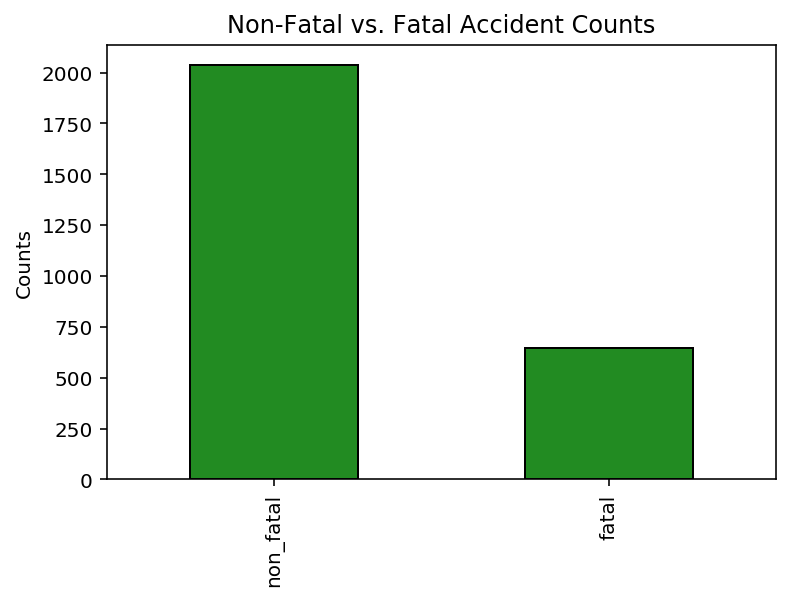

In [155]:
ax = df.fatalities.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen')
ax.set_ylabel('Counts')
_ = ax.set_title('Non-Fatal vs. Fatal Accident Counts')

Noted that my topic is not as grim as it initially sounded! However there is a class imbalance. Will try modelling using class_weight = balanced, as well as SMOTE

##  

##  This is an American dataset. I noticed during cleaning that other countries' accidents were also included so looking to see what this means for the spread of data.

In [156]:
df.country.value_counts()[:10]

 United States      2217
 Brazil               40
 Russia               31
 Australia            30
 Mexico               29
 United Kingdom       22
 Canada               21
 New Zealand          17
 Germany              16
 South Africa         13
Name: country, dtype: int64

As expected, there are alot of US accidents, however the accidents from other countries need to be investigated further. 

In [157]:
df.event_date.head(1)

0    2019-04-16
Name: event_date, dtype: object

In [158]:
df.event_date.tail(1)

2683    1982-01-02
Name: event_date, dtype: object

Used the AAIB website to check how many helicopter accident reports were filed in the UK between 2/1/1982 and 16/4/2019.  

https://www.gov.uk/aaib-reports?parent=&keywords=&aircraft_category%5B%5D=commercial-rotorcraft&aircraft_category%5B%5D=general-aviation-rotorcraft&date_of_occurrence%5Bfrom%5D=1%2F1%2F1982&date_of_occurrence%5Bto%5D=

There were 1002 helicopter accident reports during this period vs 22 in the dataset.


Will investigate the impact of the rest of the world countries further.

In [159]:
df.country=[col.strip().lower() for col in df.country]

In [160]:
df['country']=[col.replace(' ', '_') for col in df.country]

In [161]:
df['people_on_board']=df.total_fatal_injuries + df.total_serious_injuries + df.total_minor_injuries + df.total_uninjured
df.head()

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,...,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
0,hughes,369,turbine,no,2019-04-16,"Hauula, HI",united_states,Non-Fatal,business,vmc,...,unknown,21.588333,-157.911944,substantial,accident,Tuesday,4,1,professional,non_fatal
1,robinson,r44,reciprocating,no,2019-04-04,"Tampa, FL",united_states,Fatal(1),private,vmc,...,unknown,27.943333,-82.401944,substantial,accident,Thursday,4,1,private,fatal
2,robinson,r44,reciprocating,no,2019-04-02,"Taunton, MA",united_states,Non-Fatal,instructional,vmc,...,unknown,41.874445,-71.016389,substantial,accident,Tuesday,4,1,instructional,non_fatal
3,bell,222,turbine,no,2019-03-30,"Montgomery, NY",united_states,Non-Fatal,private,vmc,...,unknown,41.539444,-74.306944,substantial,accident,Saturday,3,2,private,non_fatal
4,bell,206,turbine,no,2019-03-29,"Valley Center, CA",united_states,Non-Fatal,survey,unknown,...,unknown,33.218370,-117.034197,substantial,accident,Friday,3,1,professional,non_fatal


In [162]:
len(df[(df['country'] != 'united_states') & (df['fatalities'] == 'fatal')])

314

In [163]:
len(df[(df['country'] != 'united_states') & (df['fatalities'] == 'non_fatal')])

150

In [164]:
len(df[(df['country'] == 'united_states') & (df['fatalities'] == 'fatal')])

334

In [165]:
len(df[(df['country'] == 'united_states') & (df['fatalities'] == 'non_fatal')])

1886

Accidents that occured in the US report a lower fatality rate than accidents reports from the rest of the world.

##  

Visualising this difference.

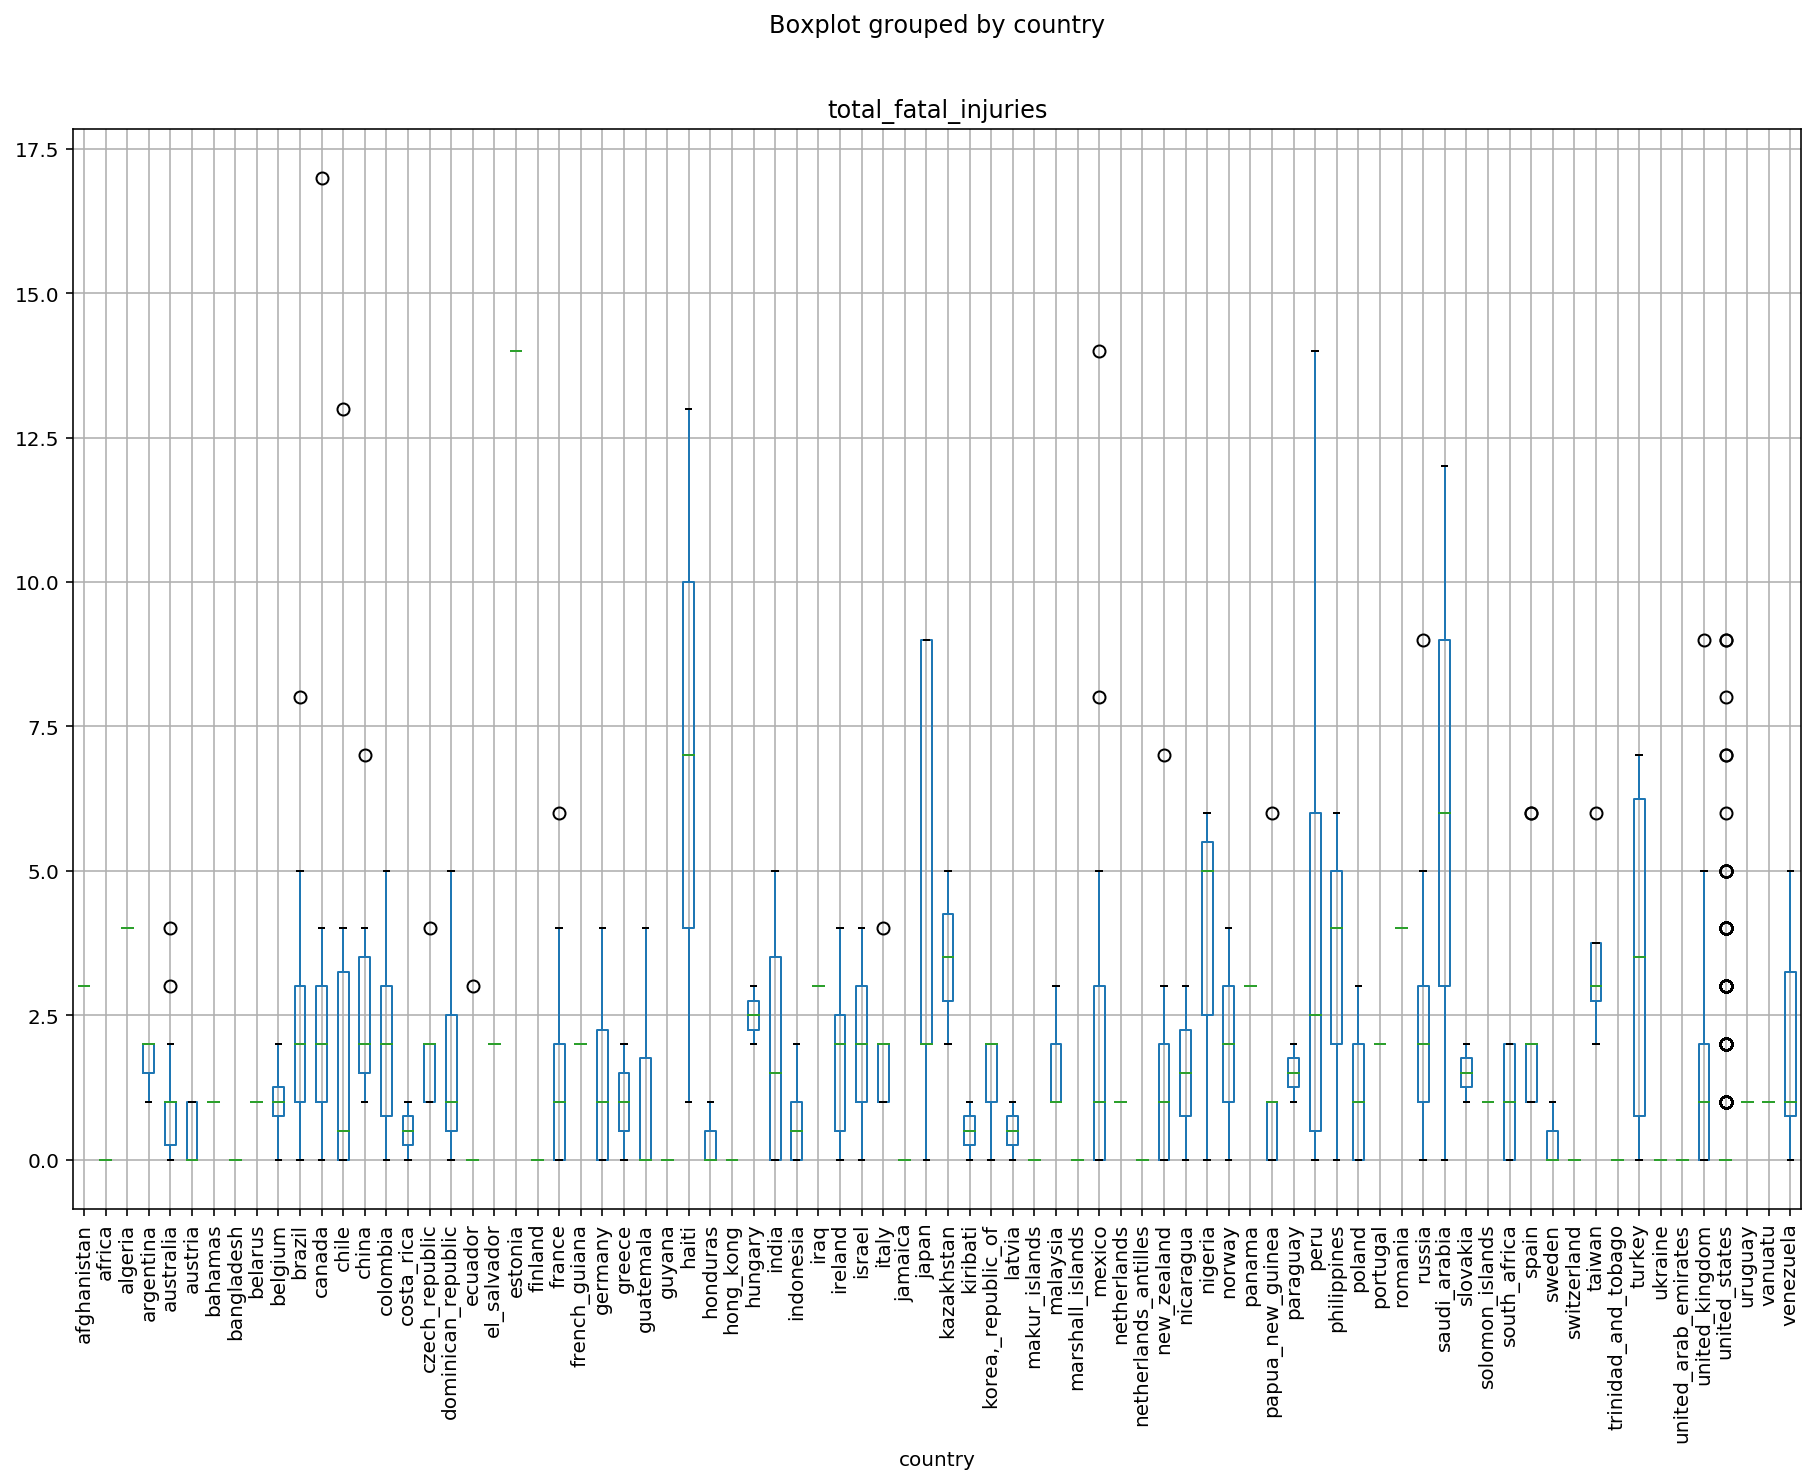

In [166]:
df.boxplot(column='total_fatal_injuries', by = 'country', rot= 90, figsize =(15,10));

The boxplot shows that the counts of accidents resulting in at least one fatality.   
The majority of U.S accidents do not result in a fatality (mean sitting on zero) 
whereas about 25% of Non_U.S reports are non-fatal.

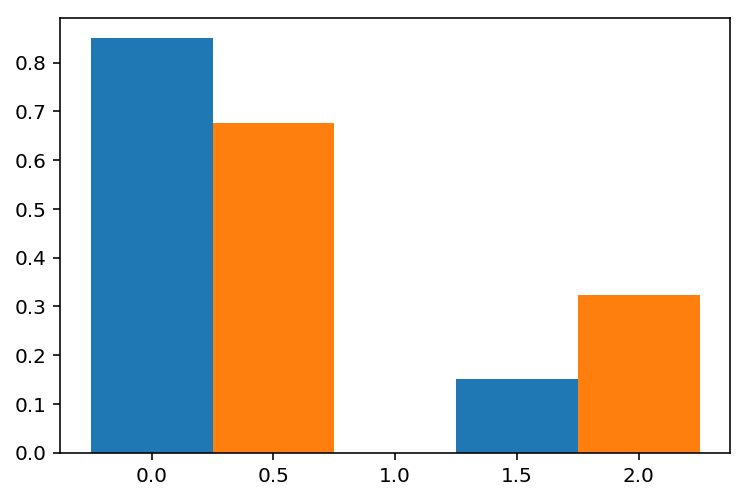

In [167]:
plt.bar([0,1.5],df[df.country == 'united_states']['fatalities'].value_counts(normalize=True),width=0.5)
plt.bar([0.5,2],df[df.country != 'united_states']['fatalities'].value_counts(normalize=True),width=0.5);

##  

In [170]:
#Tableau Map to be inserted here

Checking to see how many rows I would loose if I were to drop the rest of the world.

In [171]:
df_country=df[['country', 'total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries','total_uninjured','fatalities']]

In [172]:
def US_or_not(x):
    
    if 'united_states' in x:
        return 'US'
    else:
        return 'Non_US'
    
df_country['us_or_not'] = df.country.map(US_or_not)
print(df_country['us_or_not'].unique())
print(df_country['us_or_not'].value_counts())    

['US' 'Non_US']
US        2220
Non_US     464
Name: us_or_not, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


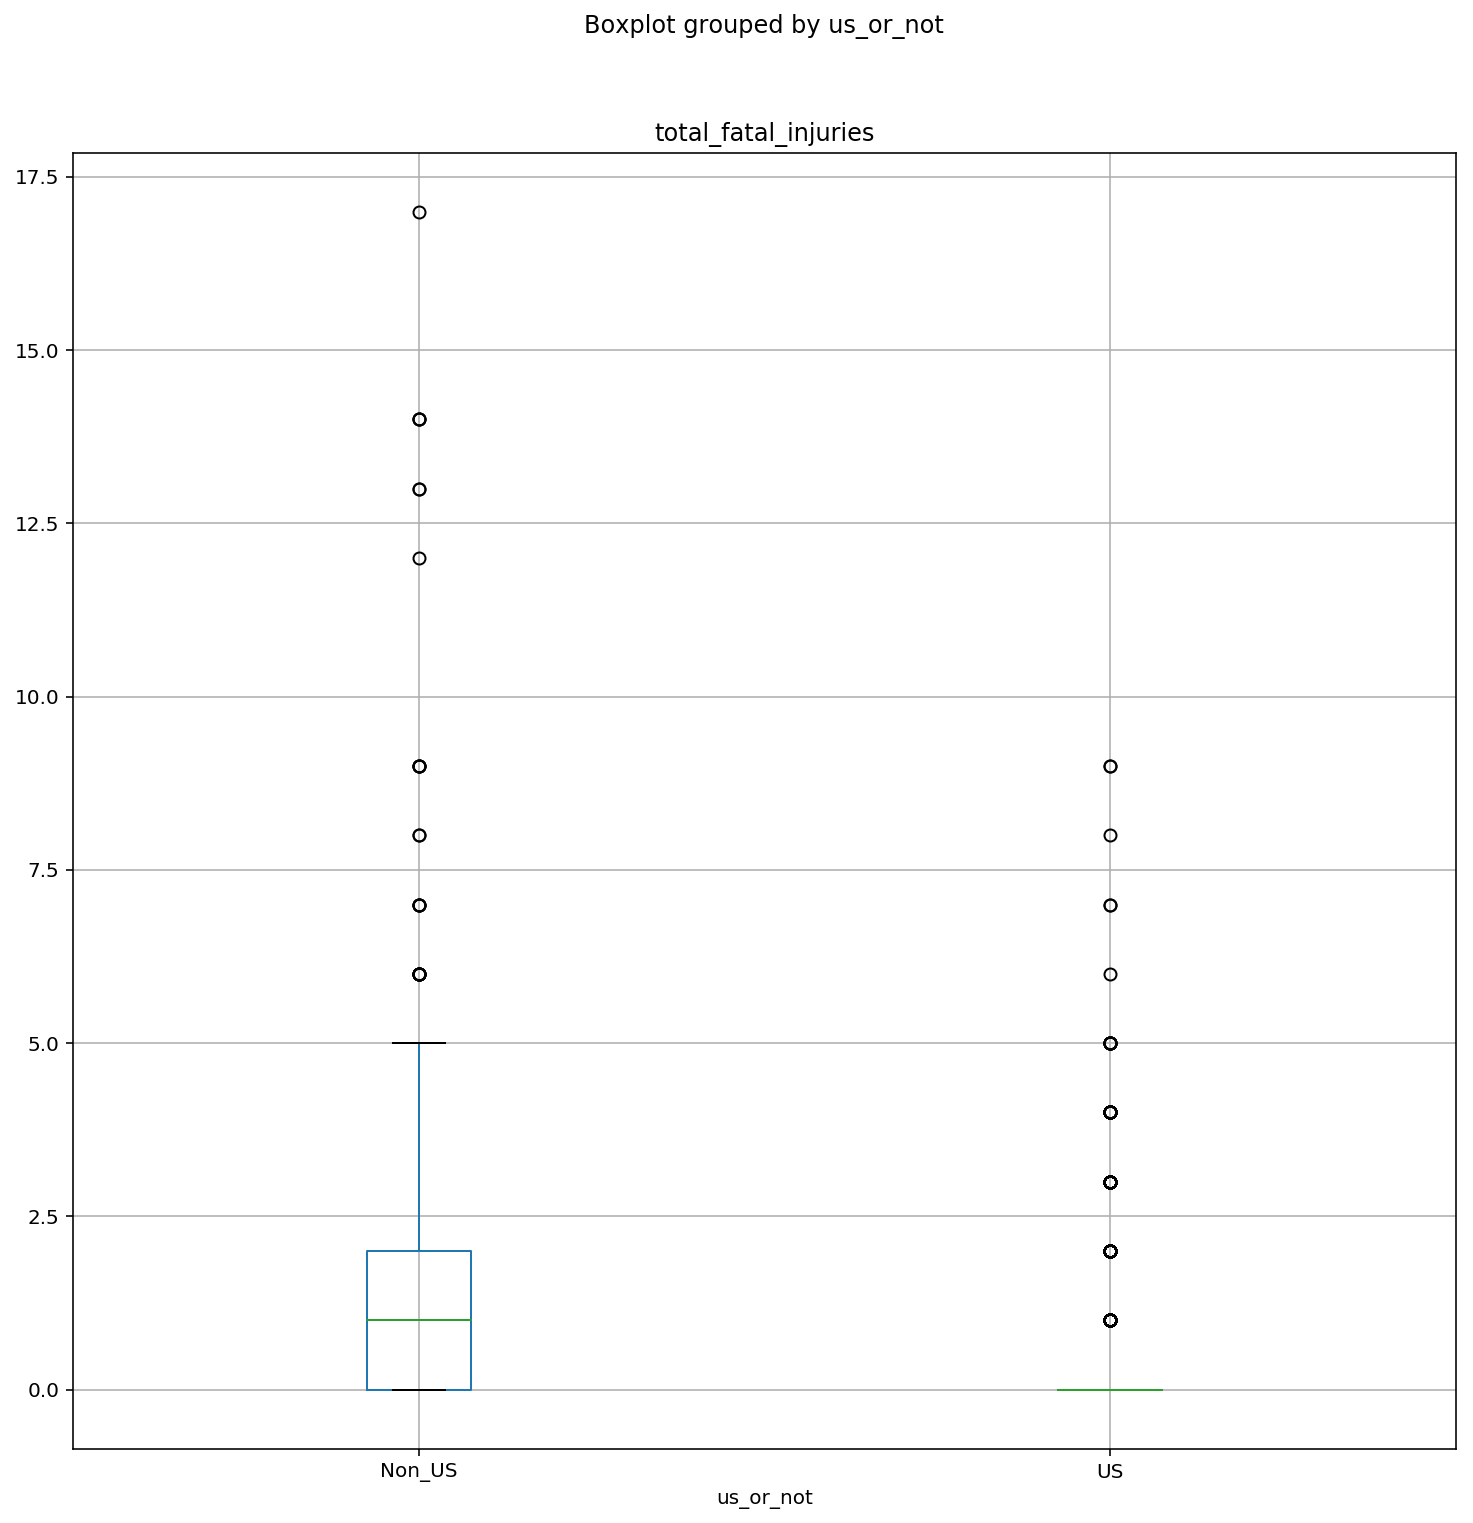

In [173]:
df_country.boxplot(column='total_fatal_injuries', by = 'us_or_not', figsize =(12,12));

Deciding to remove rest of the world from the dataset and to refine my project question to 'Surviving a Helicopter Accident in the U.S'.  

Decision to remove the rest of the world is based on: 
  
Proportions of fatalities vs non-fatalities between the US and the rest of the world and the presence of rest of the world skewing the results.
Domain knowledge of UK accidents. The UK data within the dataset, is not a complete (fatal and non-fatal).  

Assumption is that other countries data within the dataset will also be incomplete therefore skewing the data and giving a false result.

##  

##  Making a datafame that includes U.S accidents only

In [174]:
us_df=df[(df['country']== 'united_states')]

##  

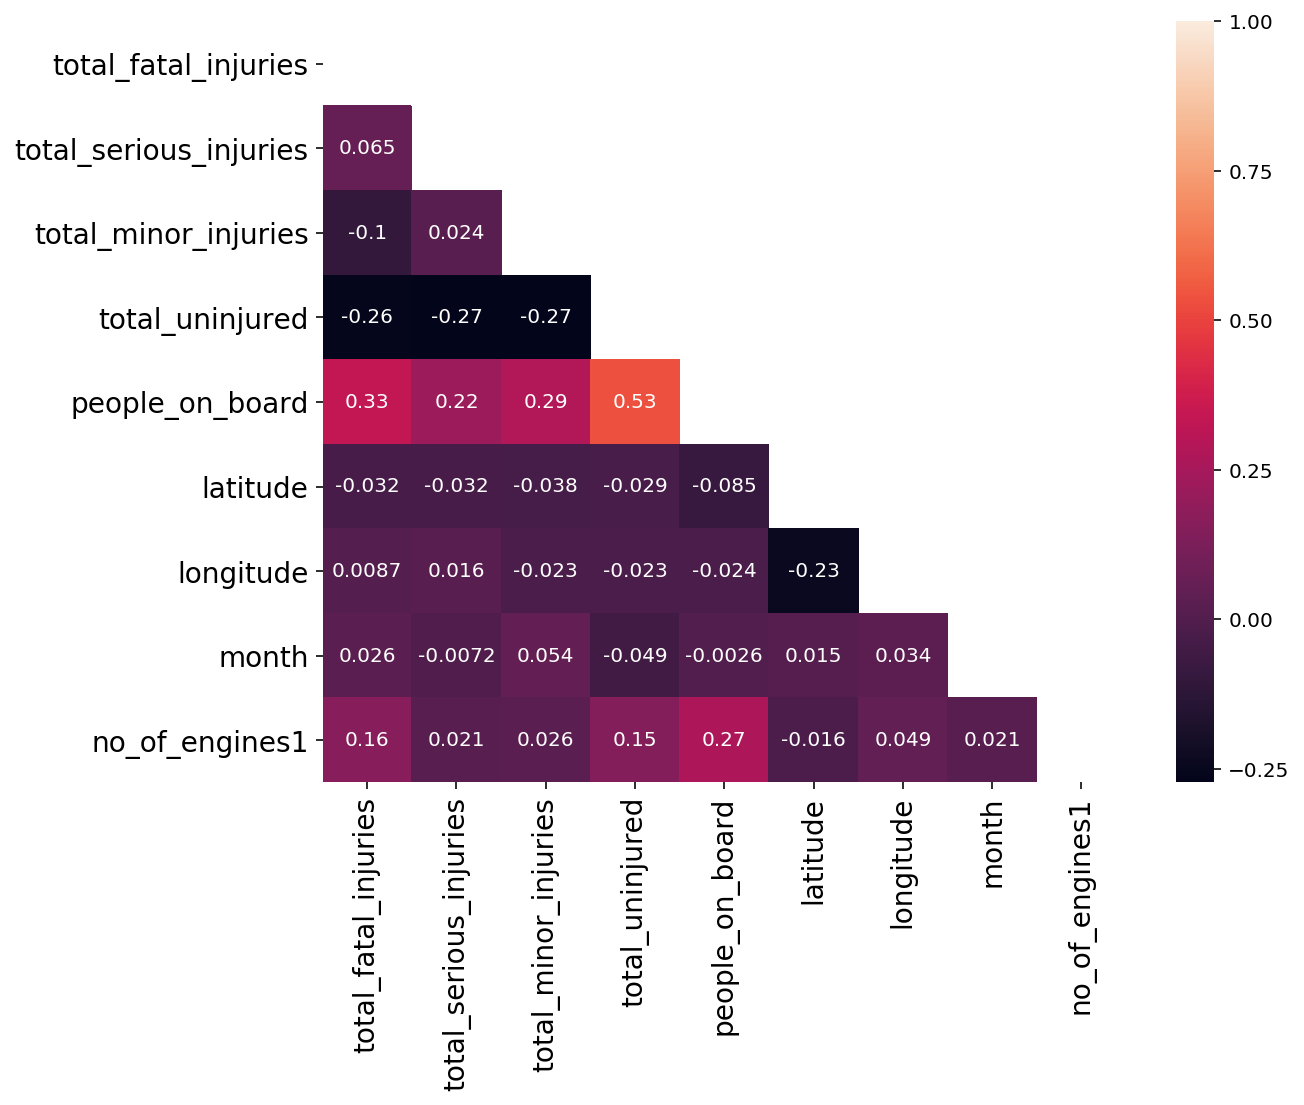

In [175]:
fig, ax = plt.subplots(figsize=(9, 7))

mask = np.zeros_like(us_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(us_df.corr(), mask=mask, annot=True, ax=ax)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

The strongest positive correlation is between people on board, and total uninjured.

##  

##  Visualising the correlation of people on board vs total_uninjured

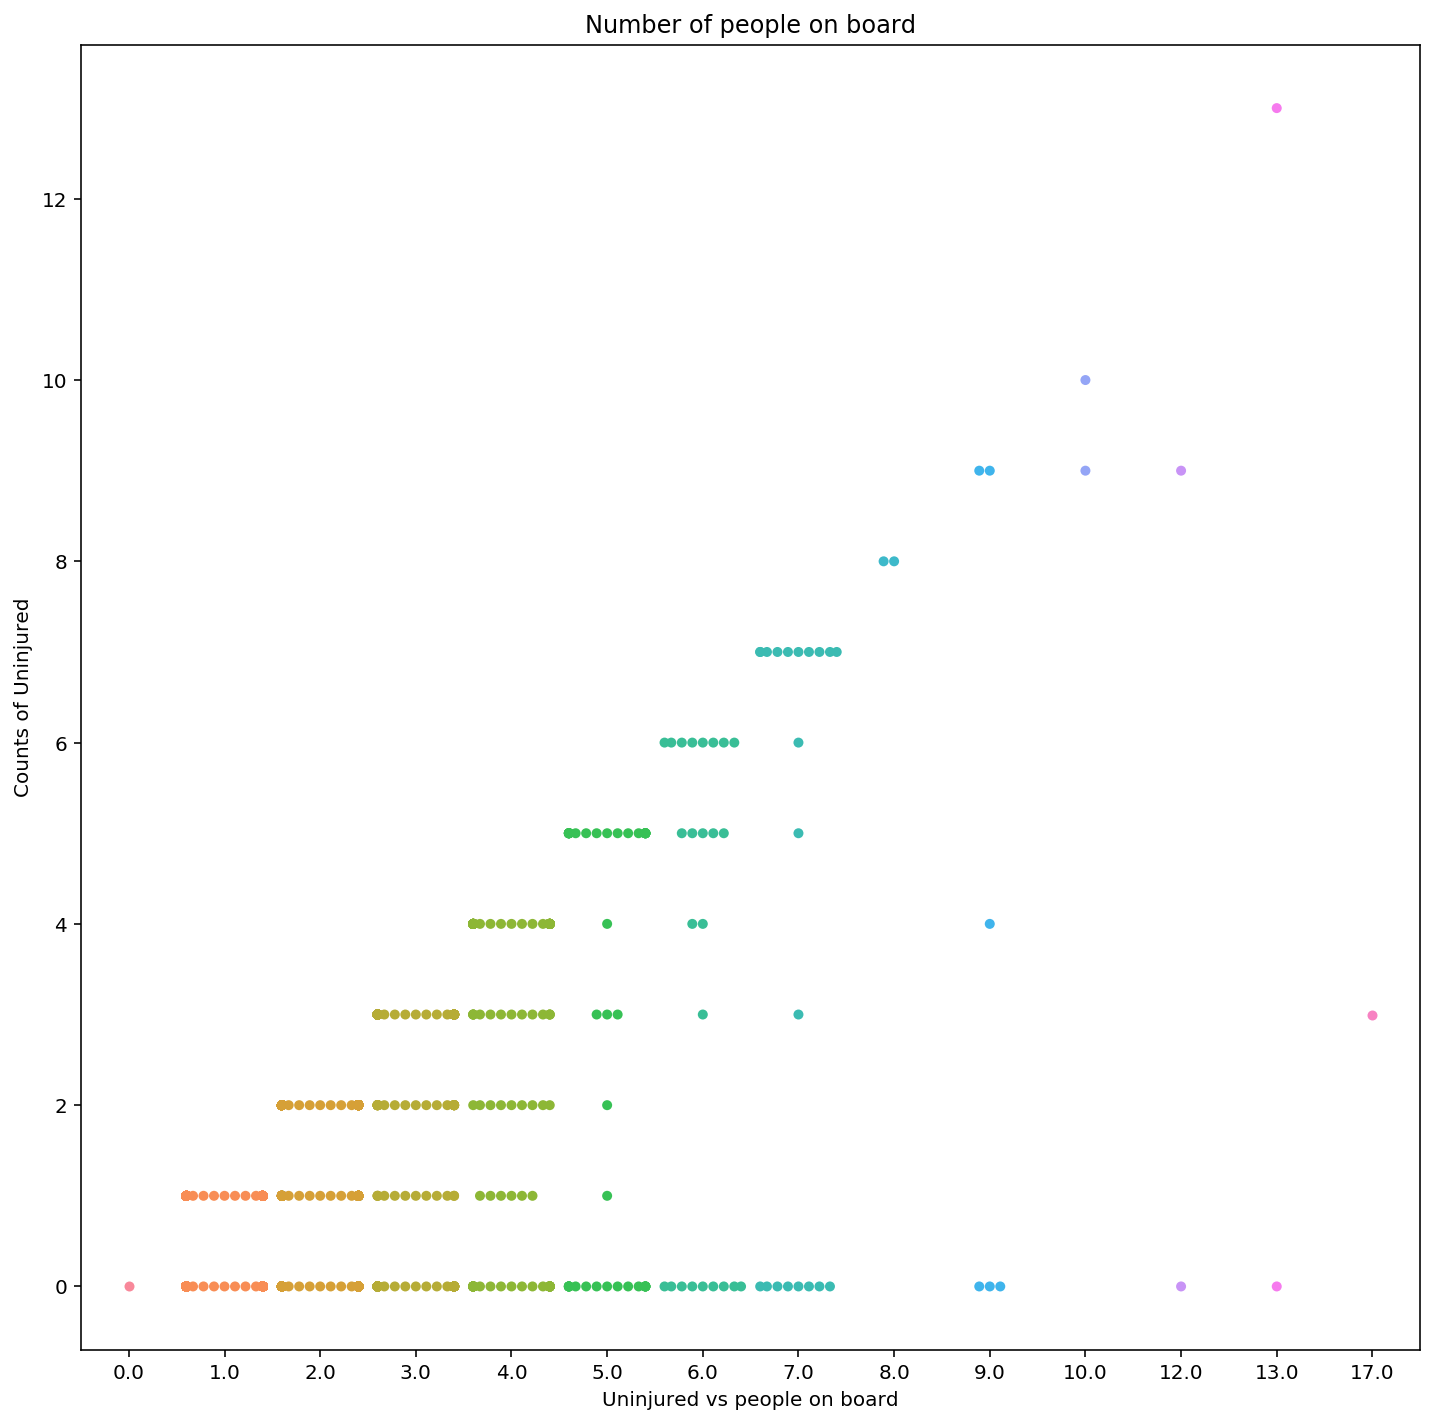

In [176]:
fig,ax = plt.subplots(figsize=(12,12))
sns.swarmplot(us_df['people_on_board'],us_df['total_uninjured'])
ax.set_ylabel('Counts of Uninjured')
_ = ax.set_title('Uninjured vs people on board')
plt.xlabel('Number of people on board');


plt.show()

##  

## Looking at Pilot Type

The pilot type column was made from data in the purpose of fight column. 
     
The reason for the generation of this column is due to the assumption that a professional pilot will have received training to a higher level than a private pilot, and will have more experience.  

Personal or private purpose of flight = pilot type -private
Instructional = pilot type -Instructional
Unknown = pilot type - Unknown
All others (which will be pilots who fly for a career) = professional


I've kept the category of 'unknown' pilot types in my dataset for now as not to drop rows, although for this plot dropping it as it does not add value. Note that the pilot type column was a made up column using the purpose of flight column. 

In [177]:
pilot=us_df[['pilot_type', 'total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']]

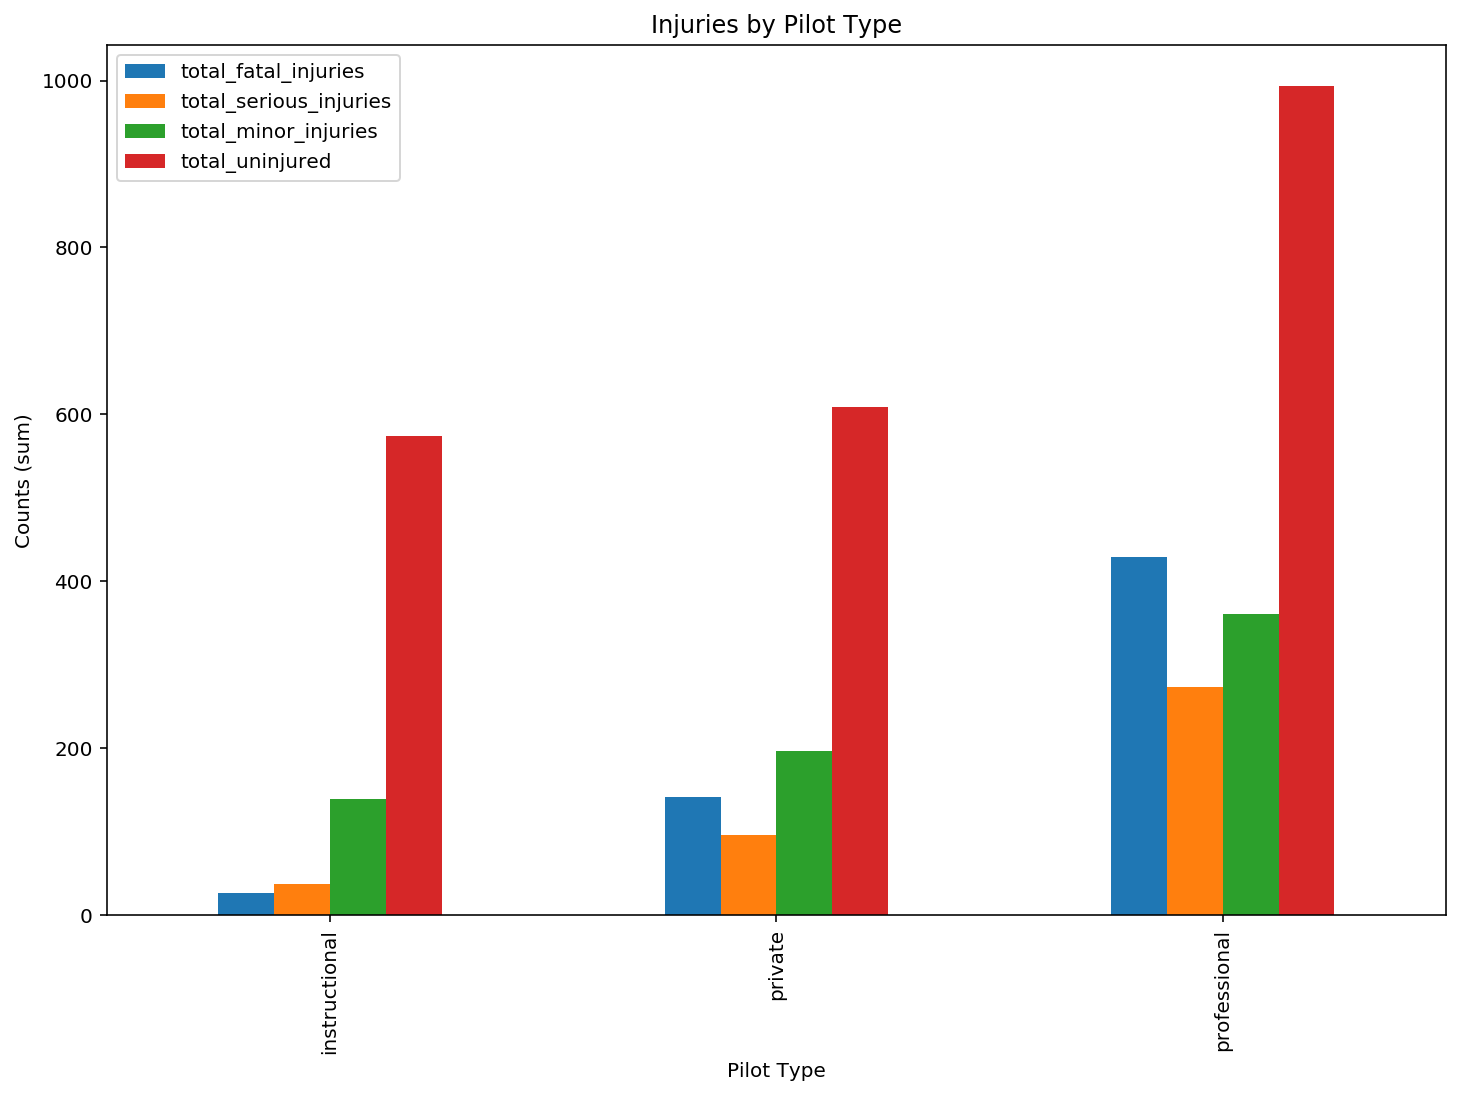

In [178]:
fig,ax = plt.subplots()
ax=pilot.groupby('pilot_type').sum().drop('unknown', axis=0).plot(kind='bar', figsize=(12,8), ax=ax);

ax.set_ylabel('Counts (sum)')
_ = ax.set_title('Injuries by Pilot Type')
plt.xlabel('Pilot Type');


Professional pilots have more accidents but this is likely to be because they fly more often.

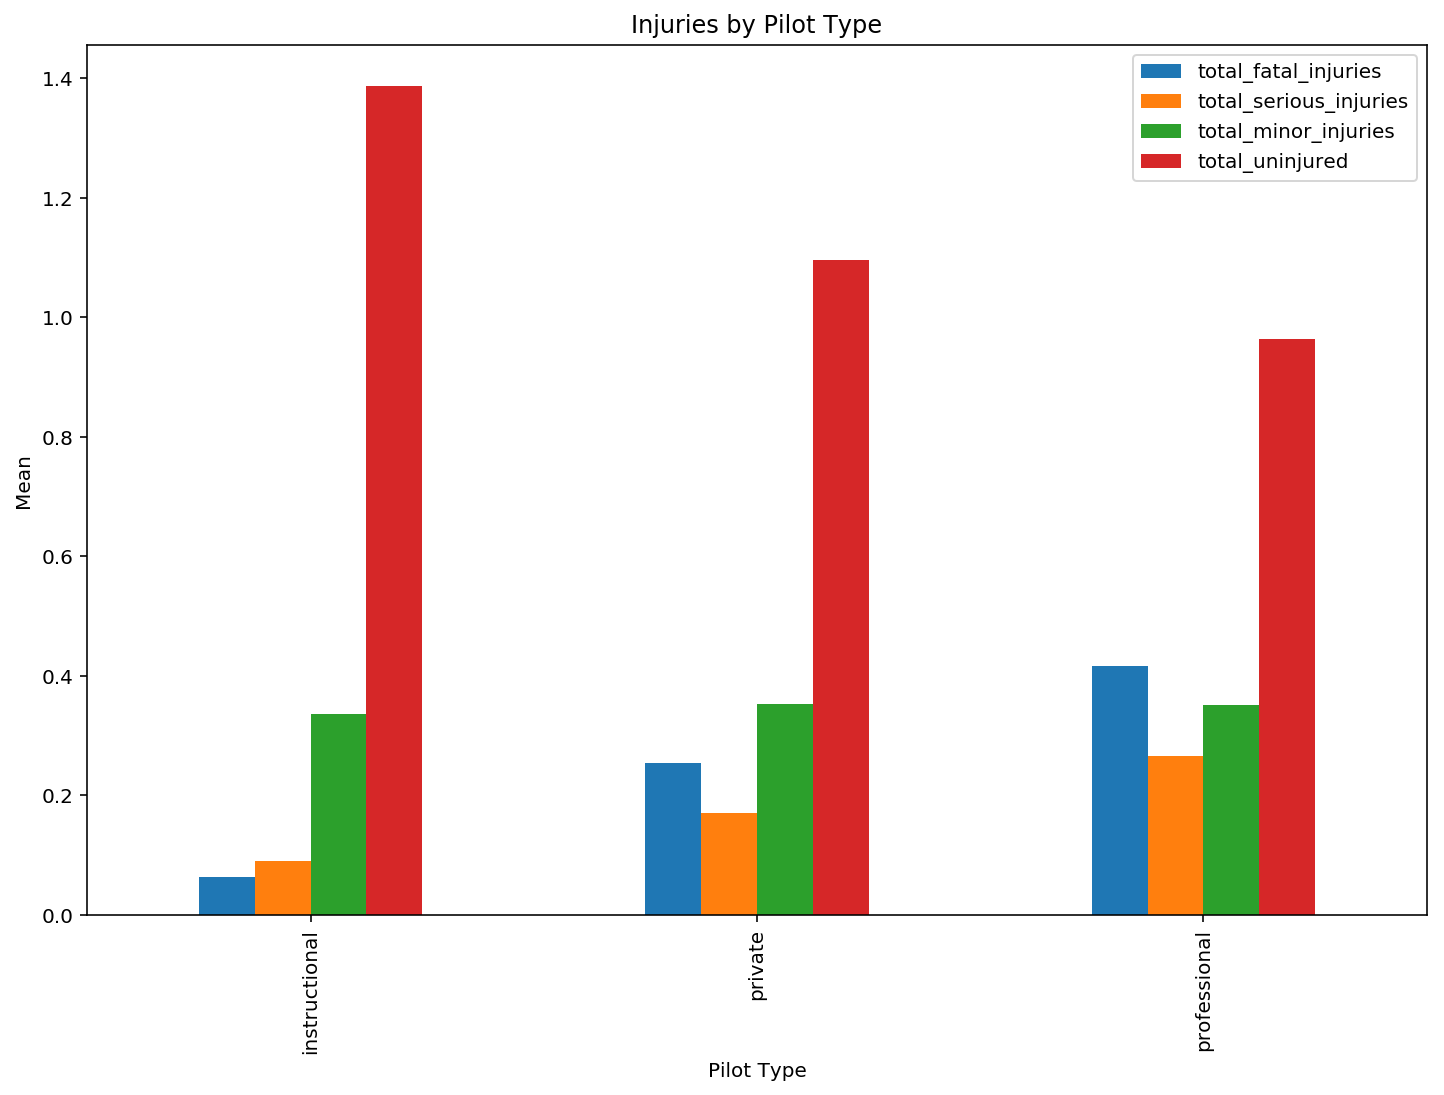

In [179]:
fig,ax = plt.subplots()
ax=pilot.groupby('pilot_type').mean().drop('unknown', axis=0).plot(kind='bar', figsize=(12,8),ax=ax);

ax.set_ylabel('Mean')
_ = ax.set_title('Injuries by Pilot Type')
plt.xlabel('Pilot Type');

Putting numbers into proportion, professional pilots are still involved with more accidents that end up with a fatality.

In [180]:
pilot.groupby('pilot_type').total_fatal_injuries.describe()

,count,mean,std,min,25%,50%,75%,max
pilot_type,,,,,,,,
instructional,414.0,0.062802,0.320287,0.0,0.0,0.0,0.0,3.0
private,556.0,0.253597,0.693915,0.0,0.0,0.0,0.0,5.0
professional,1030.0,0.416505,1.049929,0.0,0.0,0.0,0.0,9.0
unknown,220.0,0.218182,0.809553,0.0,0.0,0.0,0.0,7.0


##  

##  Now taking a closer look at instructional flights

Instructional is an interesting subset as this includes flights with instructor and student, as well as just students because students are technically unlicensed and fly on the instructors licence when flying solo.

In [181]:
len(us_df[(us_df['pilot_type'] == 'instructional') & (us_df['fatalities'] != 'fatal')&(us_df['people_on_board']==2)])

318

In [182]:
len(us_df[(us_df['pilot_type'] == 'instructional') & (us_df['fatalities'] != 'fatal')&(us_df['people_on_board']==1)])

65

In [183]:
len(us_df[(us_df['pilot_type'] == 'instructional') & (us_df['fatalities'] == 'fatal')&(us_df['people_on_board']==2)])

10

In [184]:
len(us_df[(us_df['pilot_type'] == 'instructional') & (us_df['fatalities'] == 'fatal')&(us_df['people_on_board']==1)])

7

It looks like seven students have died while flying solo

##  

## Now looking at weather

A private helicopter pilot is taught to fly using visual references, and therefore must stay out of cloud where you can quickly loose your sense of direction, attitude. Within the dataset, fine weather is defined as VMC, and clouds/limited visibility is IMC.   

This is to investigate accidents where the pilot has ended up in IMC.

In [185]:
weather = us_df[['weather_condition','total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']]

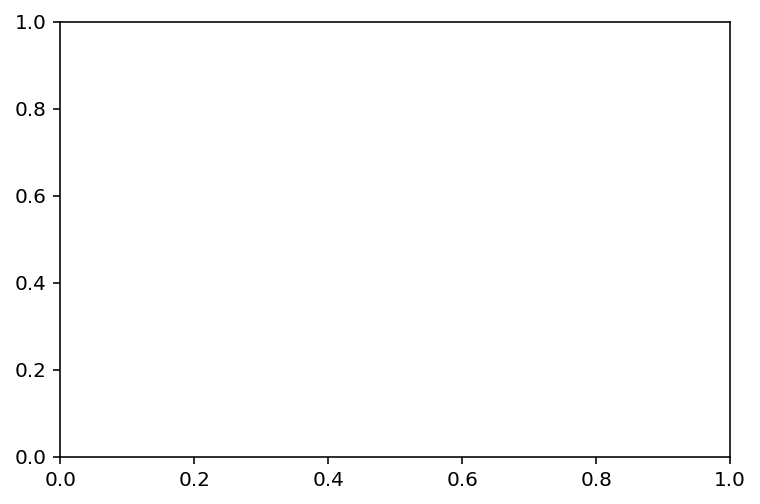

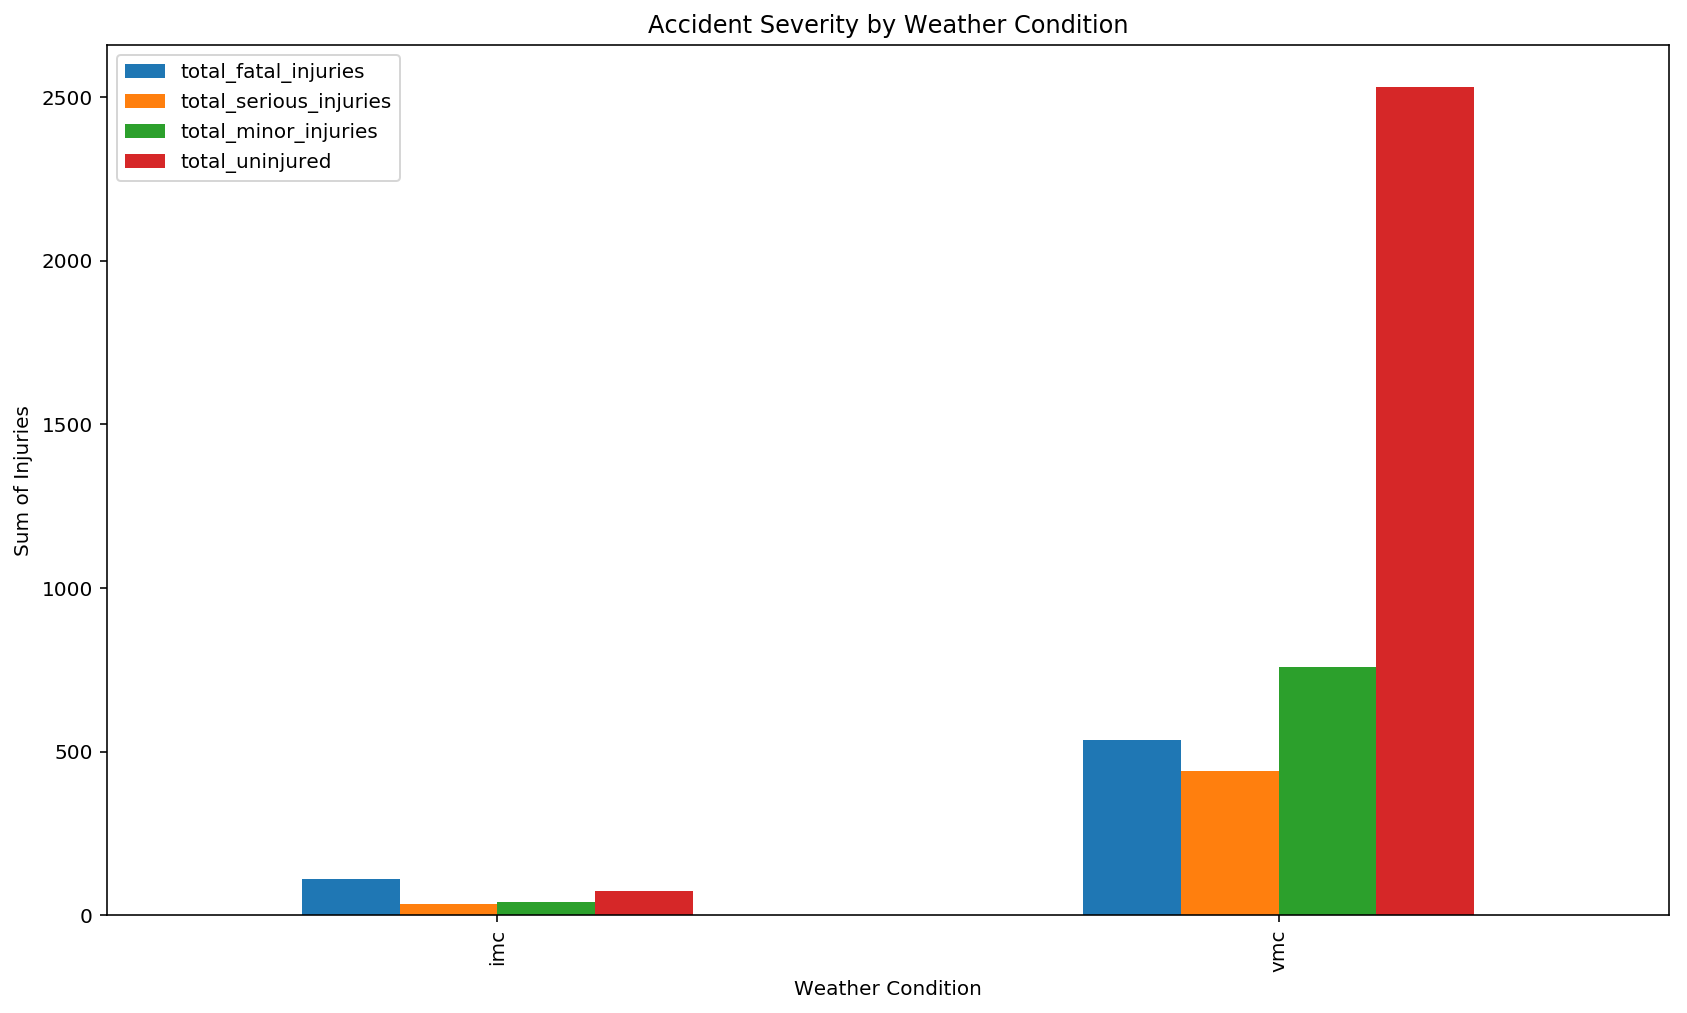

In [186]:
fig,ax = plt.subplots()
ax=weather.groupby(['weather_condition'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].sum().drop('unknown', axis=0).plot(kind='bar', figsize = (14,8));

ax.set_ylabel('Sum of Injuries')
ax.set_title('Accident Severity by Weather Condition')
plt.xlabel('Weather Condition');

Most accidents happen in fine weather. 

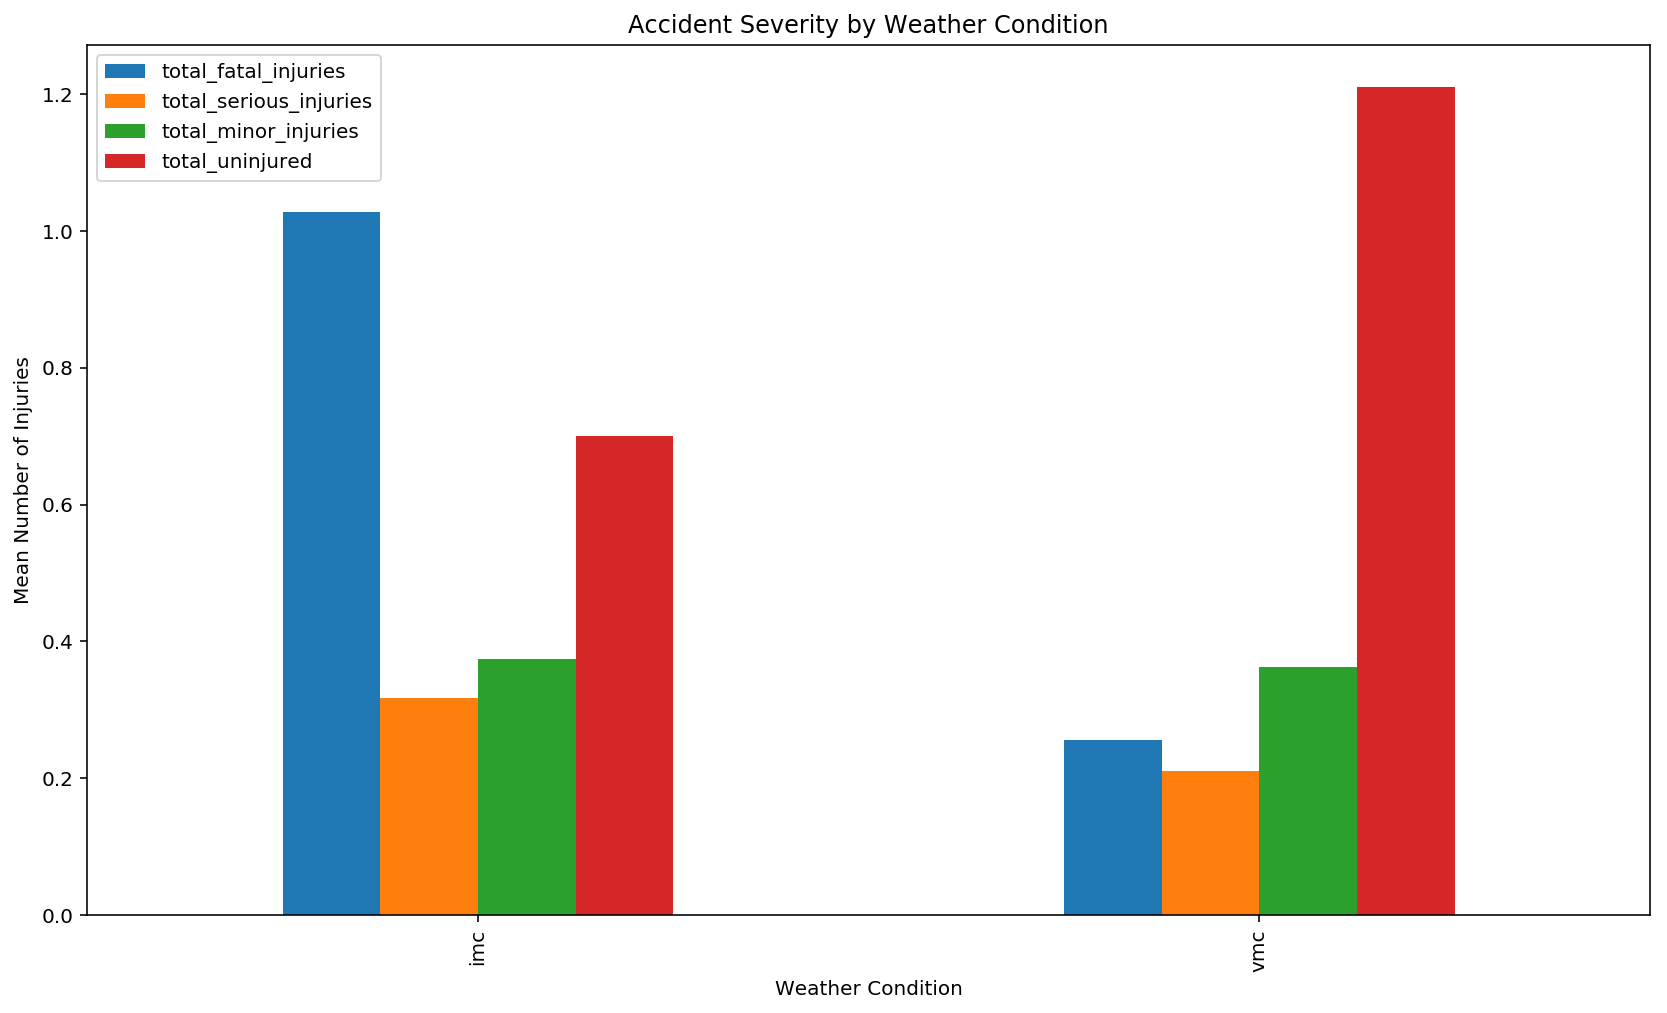

In [187]:
fig,ax = plt.subplots()
weather.groupby(['weather_condition'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].mean().drop('unknown').plot(kind='bar', figsize = (14,8),ax=ax);

ax.set_ylabel('Mean Number of Injuries')
ax.set_title('Accident Severity by Weather Condition')
plt.xlabel('Weather Condition');


It looks like inadvertently ending up in IMC is as bad as it sounds.

##  

##  Does day of the week make a difference?

In [188]:
dow = us_df[['day_of_week','total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']]

In [189]:
dow.groupby('day_of_week').total_fatal_injuries.value_counts()

day_of_week  total_fatal_injuries
Friday       0.0                     315
             1.0                      29
             2.0                      13
             3.0                       8
             4.0                       4
             6.0                       1
Monday       0.0                     238
             1.0                      24
             2.0                      11
             3.0                       6
             4.0                       2
             5.0                       1
Saturday     0.0                     300
             1.0                      30
             3.0                      12
             2.0                       7
             4.0                       3
             5.0                       1
             9.0                       1
Sunday       0.0                     221
             1.0                      26
             2.0                       7
             3.0                       6
             4.0       

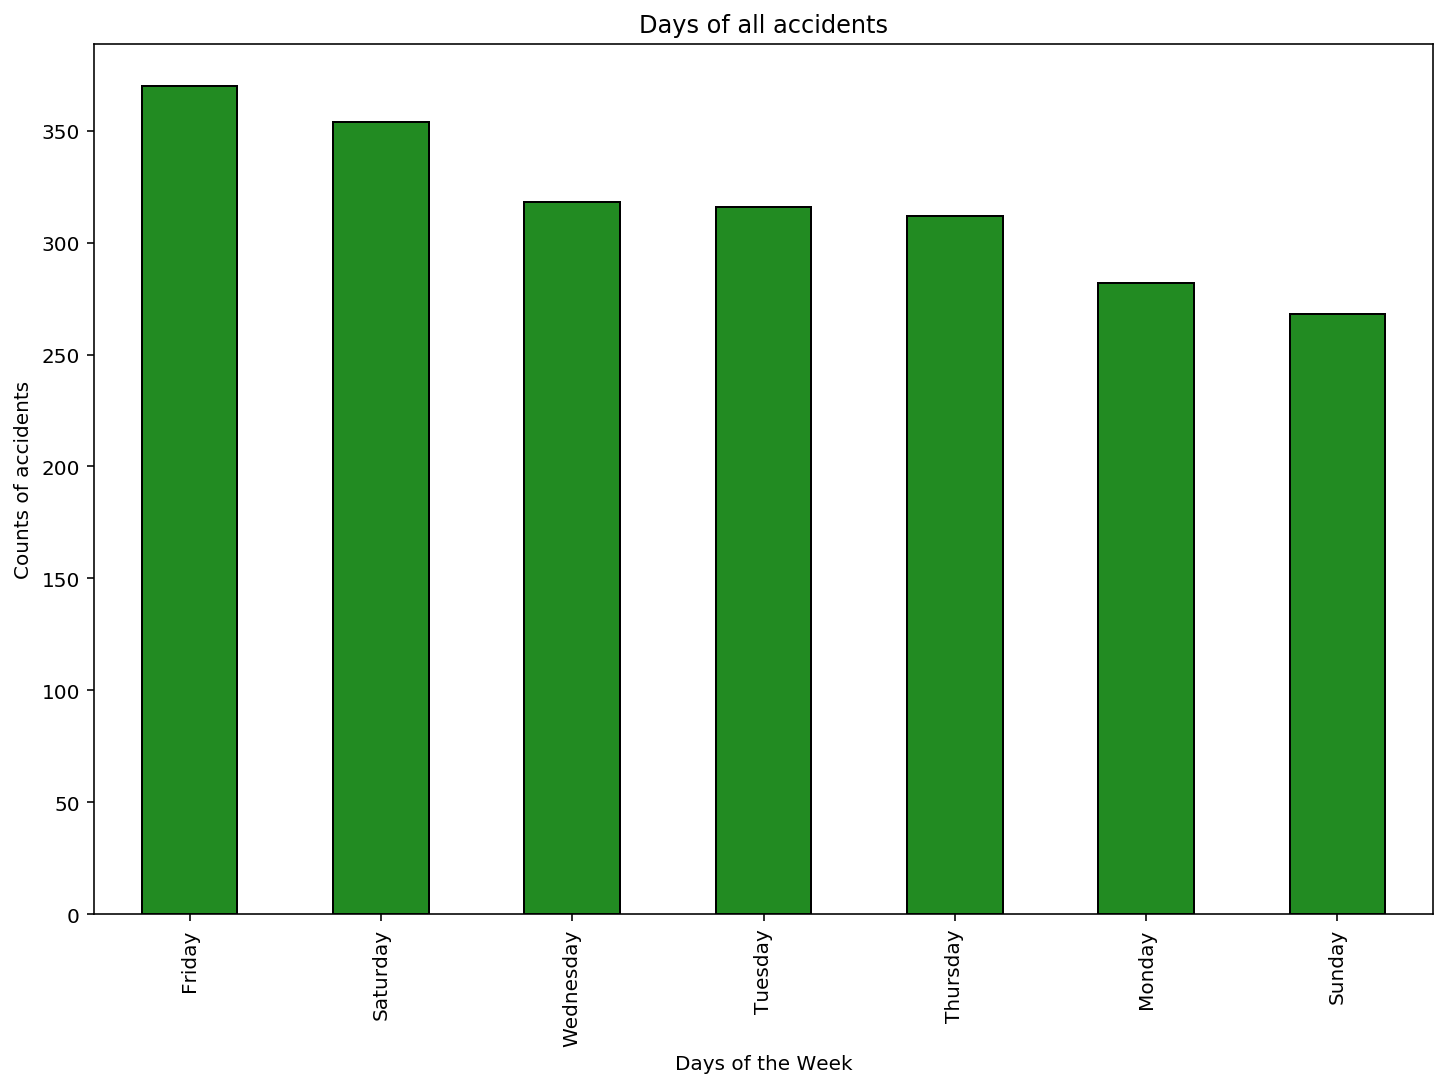

In [190]:
ax = us_df.day_of_week.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen', figsize = (12,8));
ax.set_ylabel('Counts of accidents')
_ = ax.set_title('Days of all accidents')
plt.xlabel('Days of the Week');

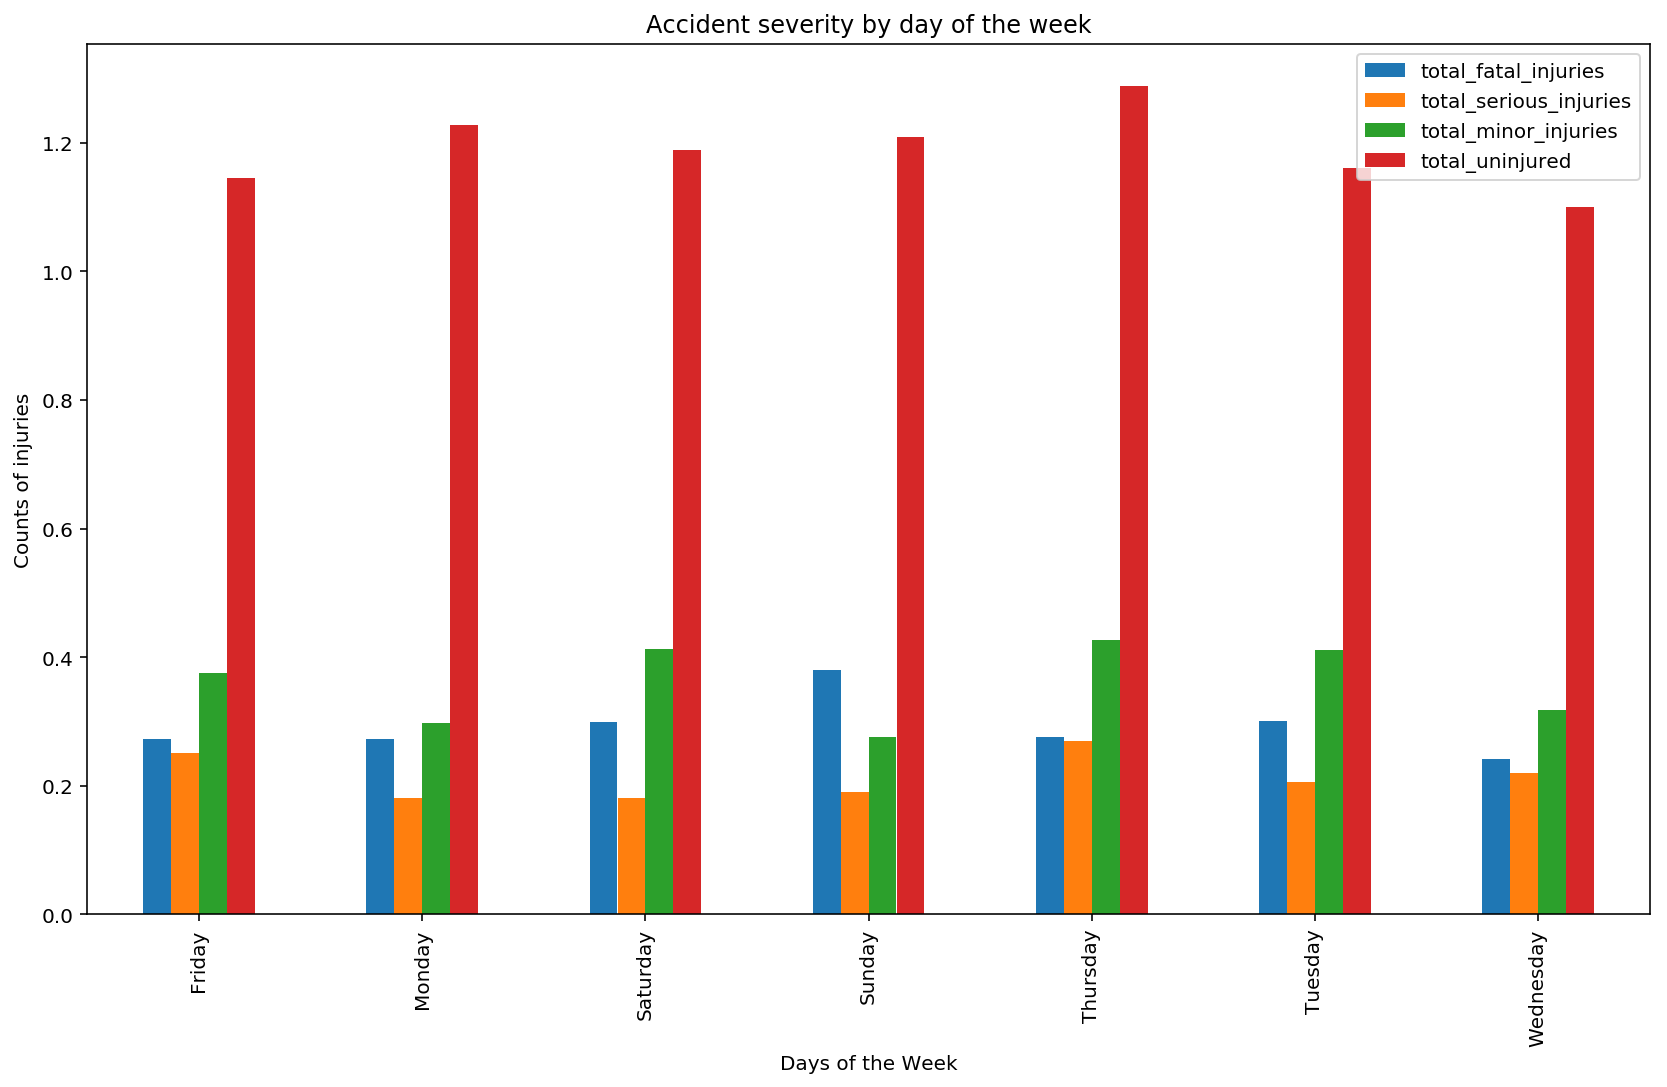

In [191]:
ax=dow.groupby(['day_of_week'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].mean().plot(kind='bar', figsize = (14,8));
ax.set_ylabel('Counts of injuries')
_ = ax.set_title('Accident severity by day of the week')
plt.xlabel('Days of the Week');


It looks like Sunday is the most fatal day to fly.

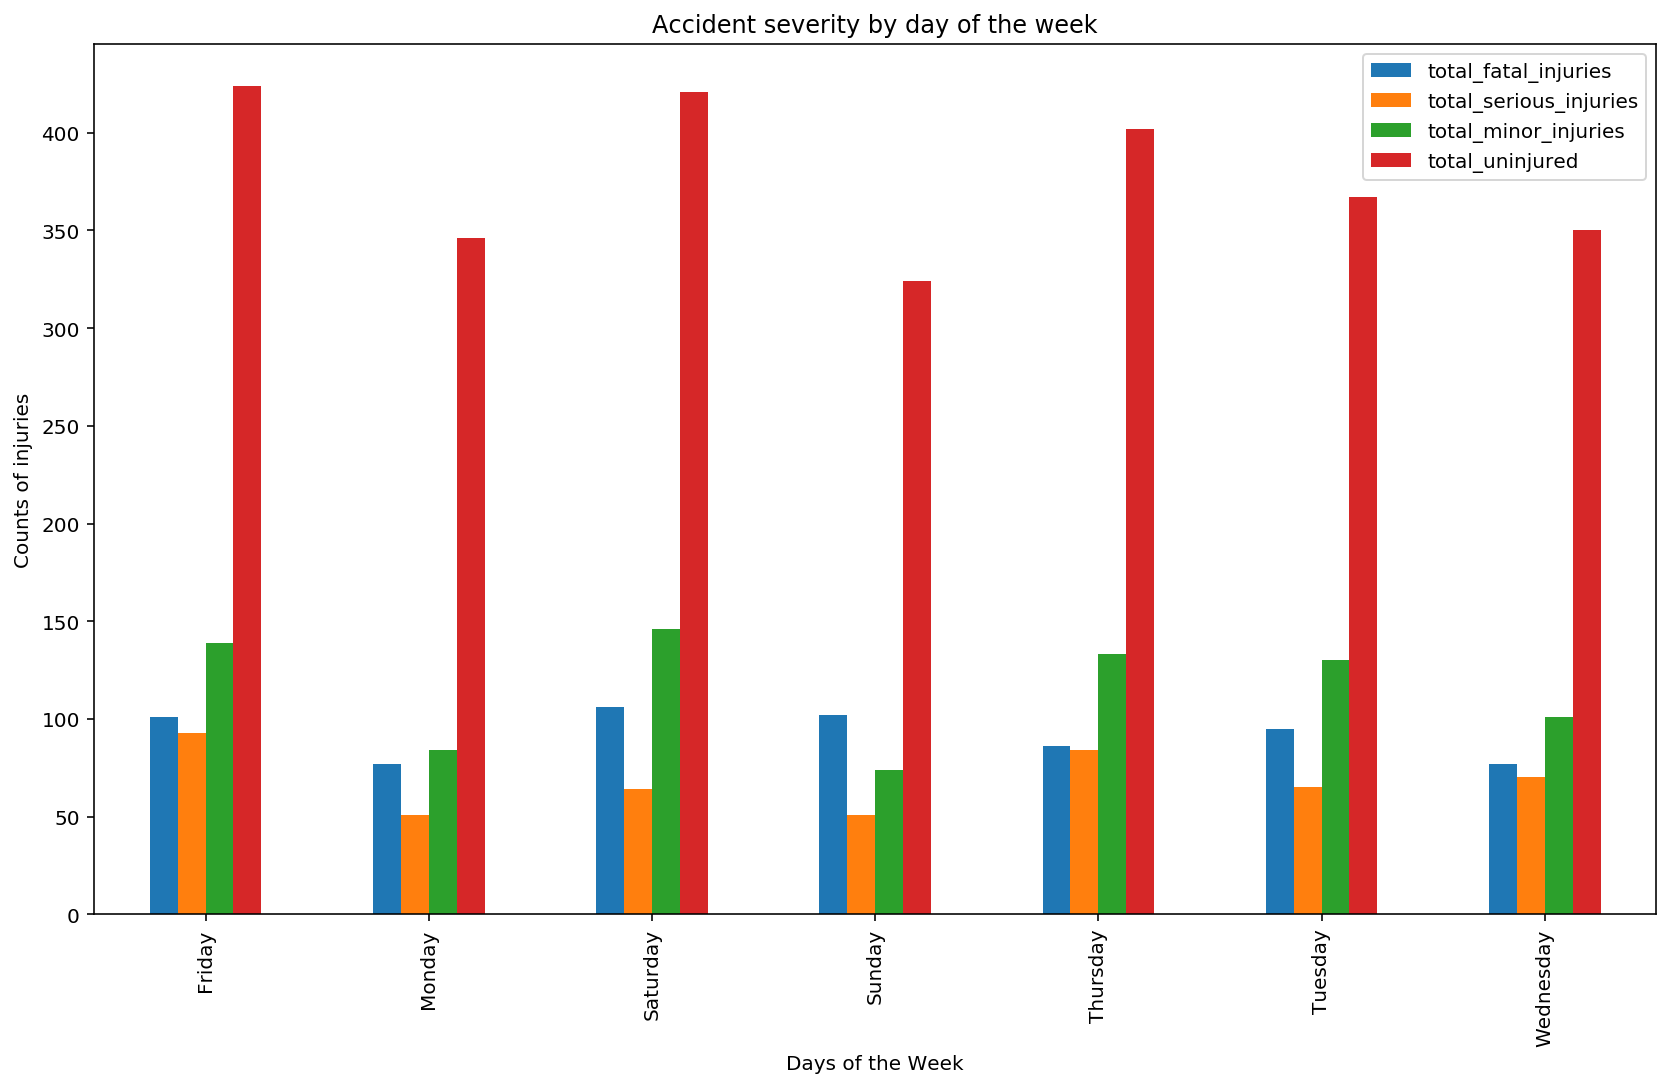

In [192]:
ax=dow.groupby(['day_of_week'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].sum().plot(kind='bar', figsize = (14,8));
ax.set_ylabel('Counts of injuries')
_ = ax.set_title('Accident severity by day of the week')
plt.xlabel('Days of the Week');

##  

Also wondering about if there is anything to be seen with private pilots seasonal safety, ie, if they have not flown over the Winter and are therefore rusty and more dangerous in Spring. Google says the American winter starts at the end of December, and that seasons are felt from about latitude 40N

In [193]:
season=us_df[(us_df['latitude']>40) & (us_df['pilot_type']=='private')]

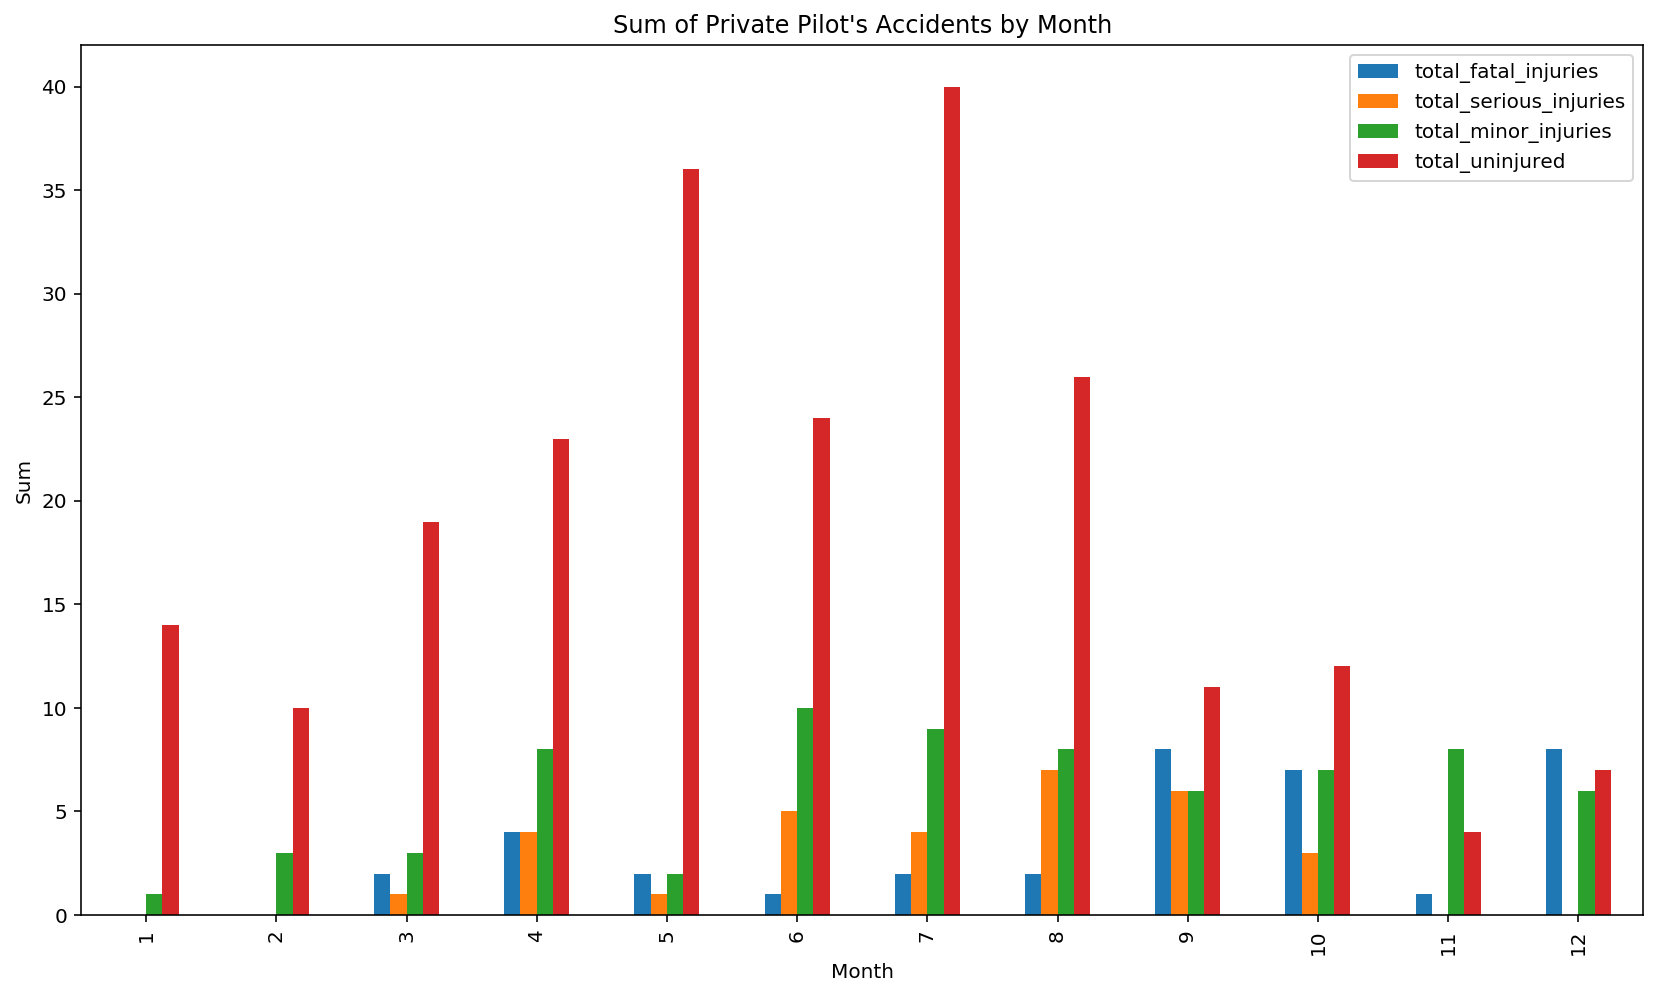

In [202]:
season.groupby(['month'])['total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].sum().plot(kind='bar', figsize = (14,8))
plt.ylabel('Sum')
plt.xlabel('Month')
plt.title("Sum of Private Pilot's Accidents by Month");

While the number of fatalities is greater in April than earlier in the year, September, October and December look to be more fata..

Looking at all accidents by month.

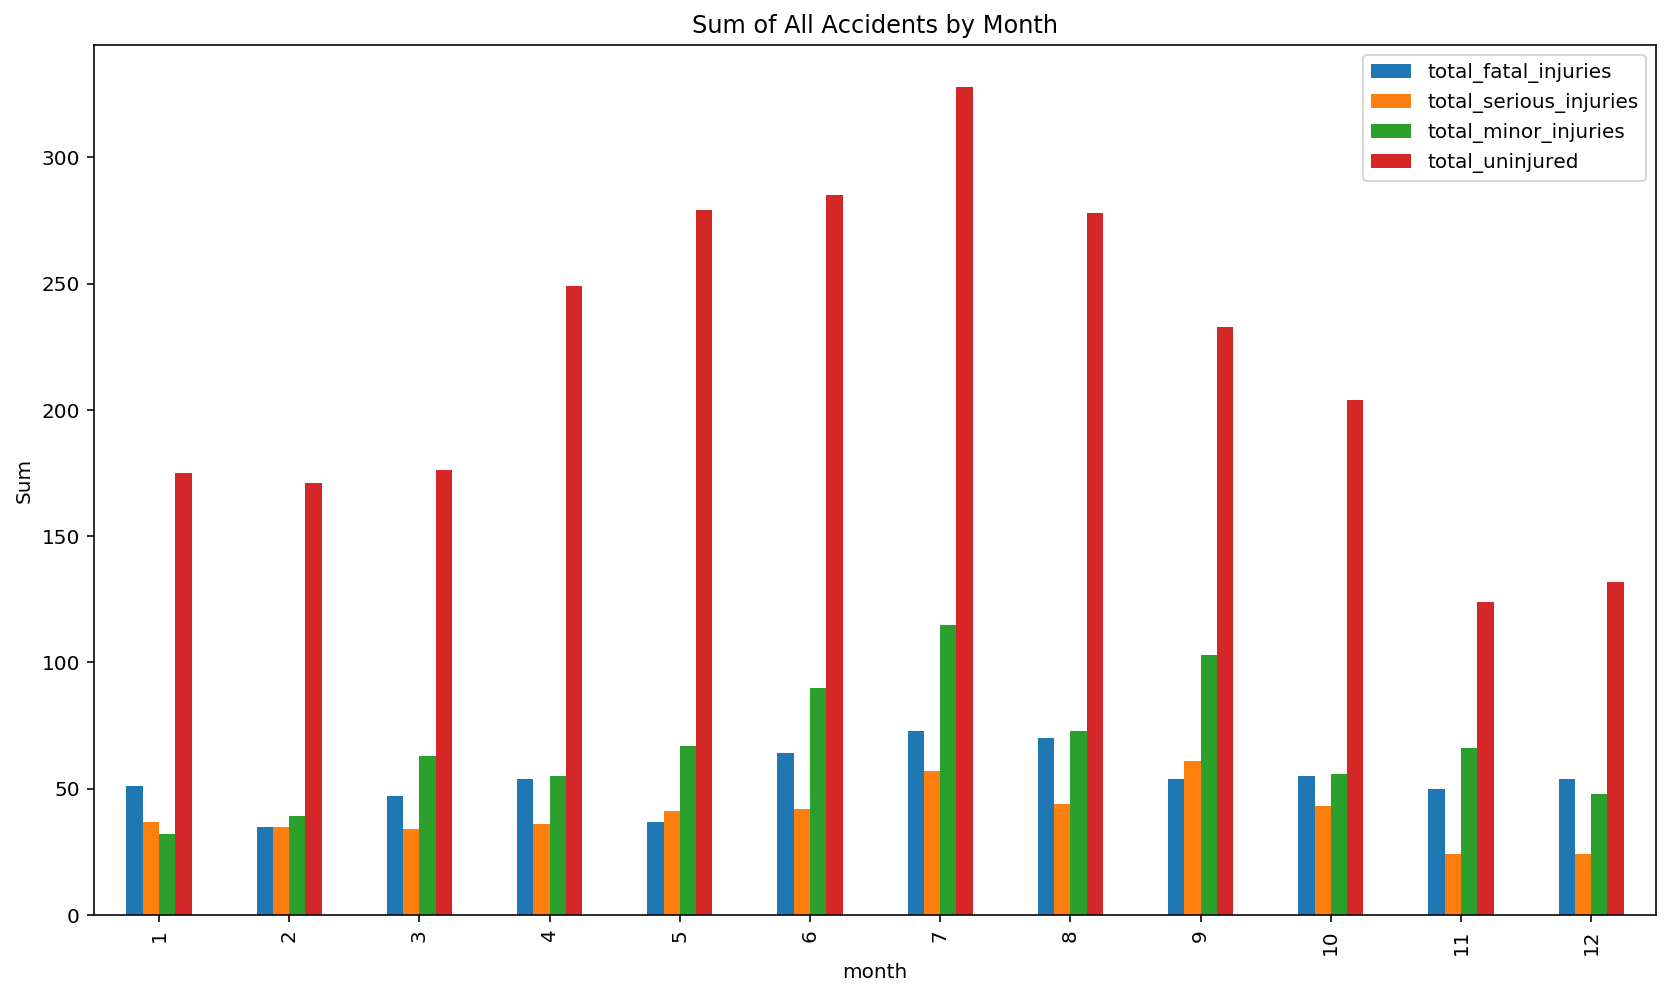

In [200]:
us_df.groupby(['month'])['total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].sum().plot(kind='bar', figsize = (14,8))
plt.ylabel('Sum')
plt.title("Sum of All Accidents by Month");

No trends to be seen.

##  

##  Looking at Helicopter types

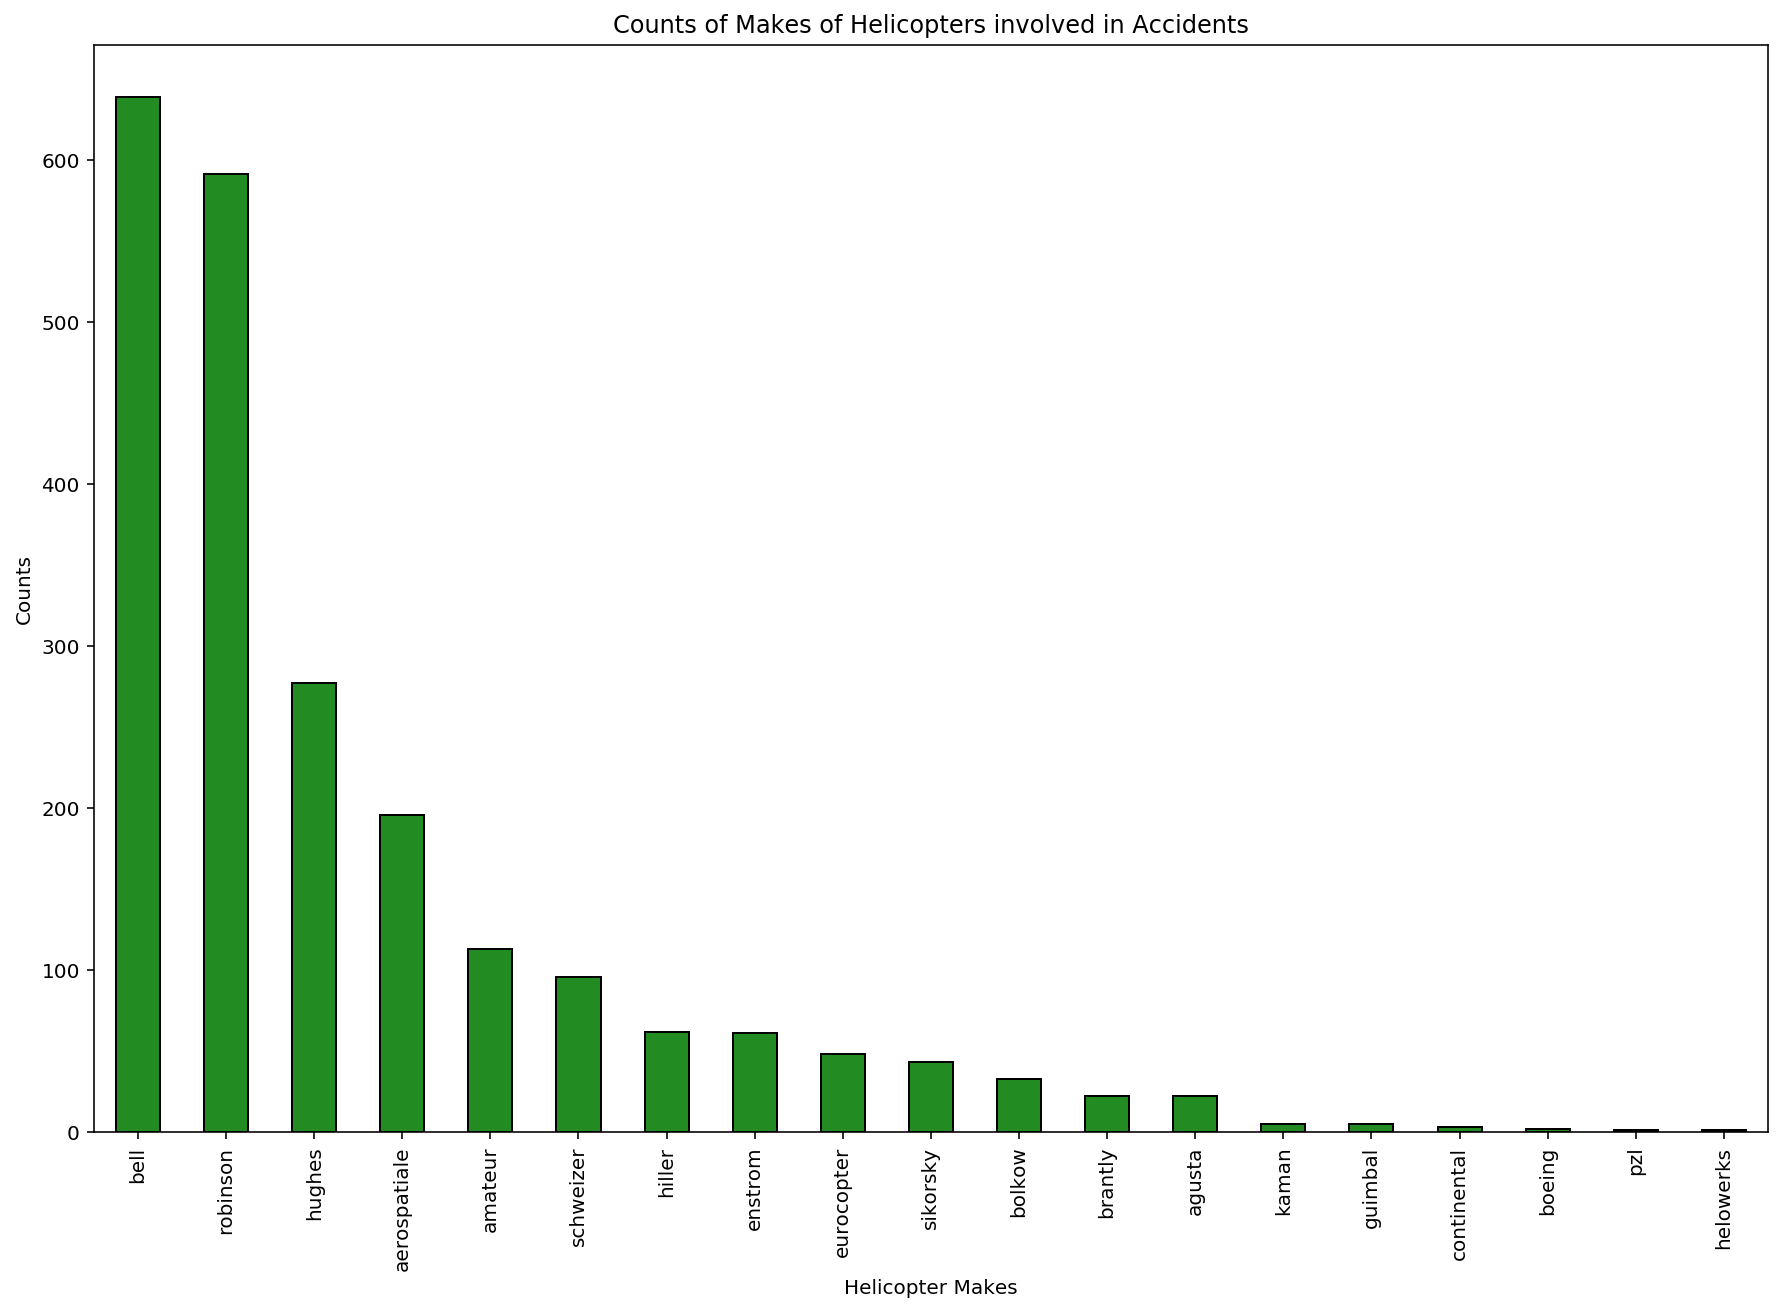

In [196]:
fig,ax=plt.subplots(figsize = [15,10])
ax = us_df.make.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen')
ax.set_ylabel('Counts')
ax.set_xlabel('Helicopter Makes')
_ = ax.set_title('Counts of Makes of Helicopters involved in Accidents')

Without knowing the number of flights (without accidents) it is difficult to say if this is relevant. Of private pilots
in the UK, common helicopter makes are Robinson, Bell and Eurocopter.

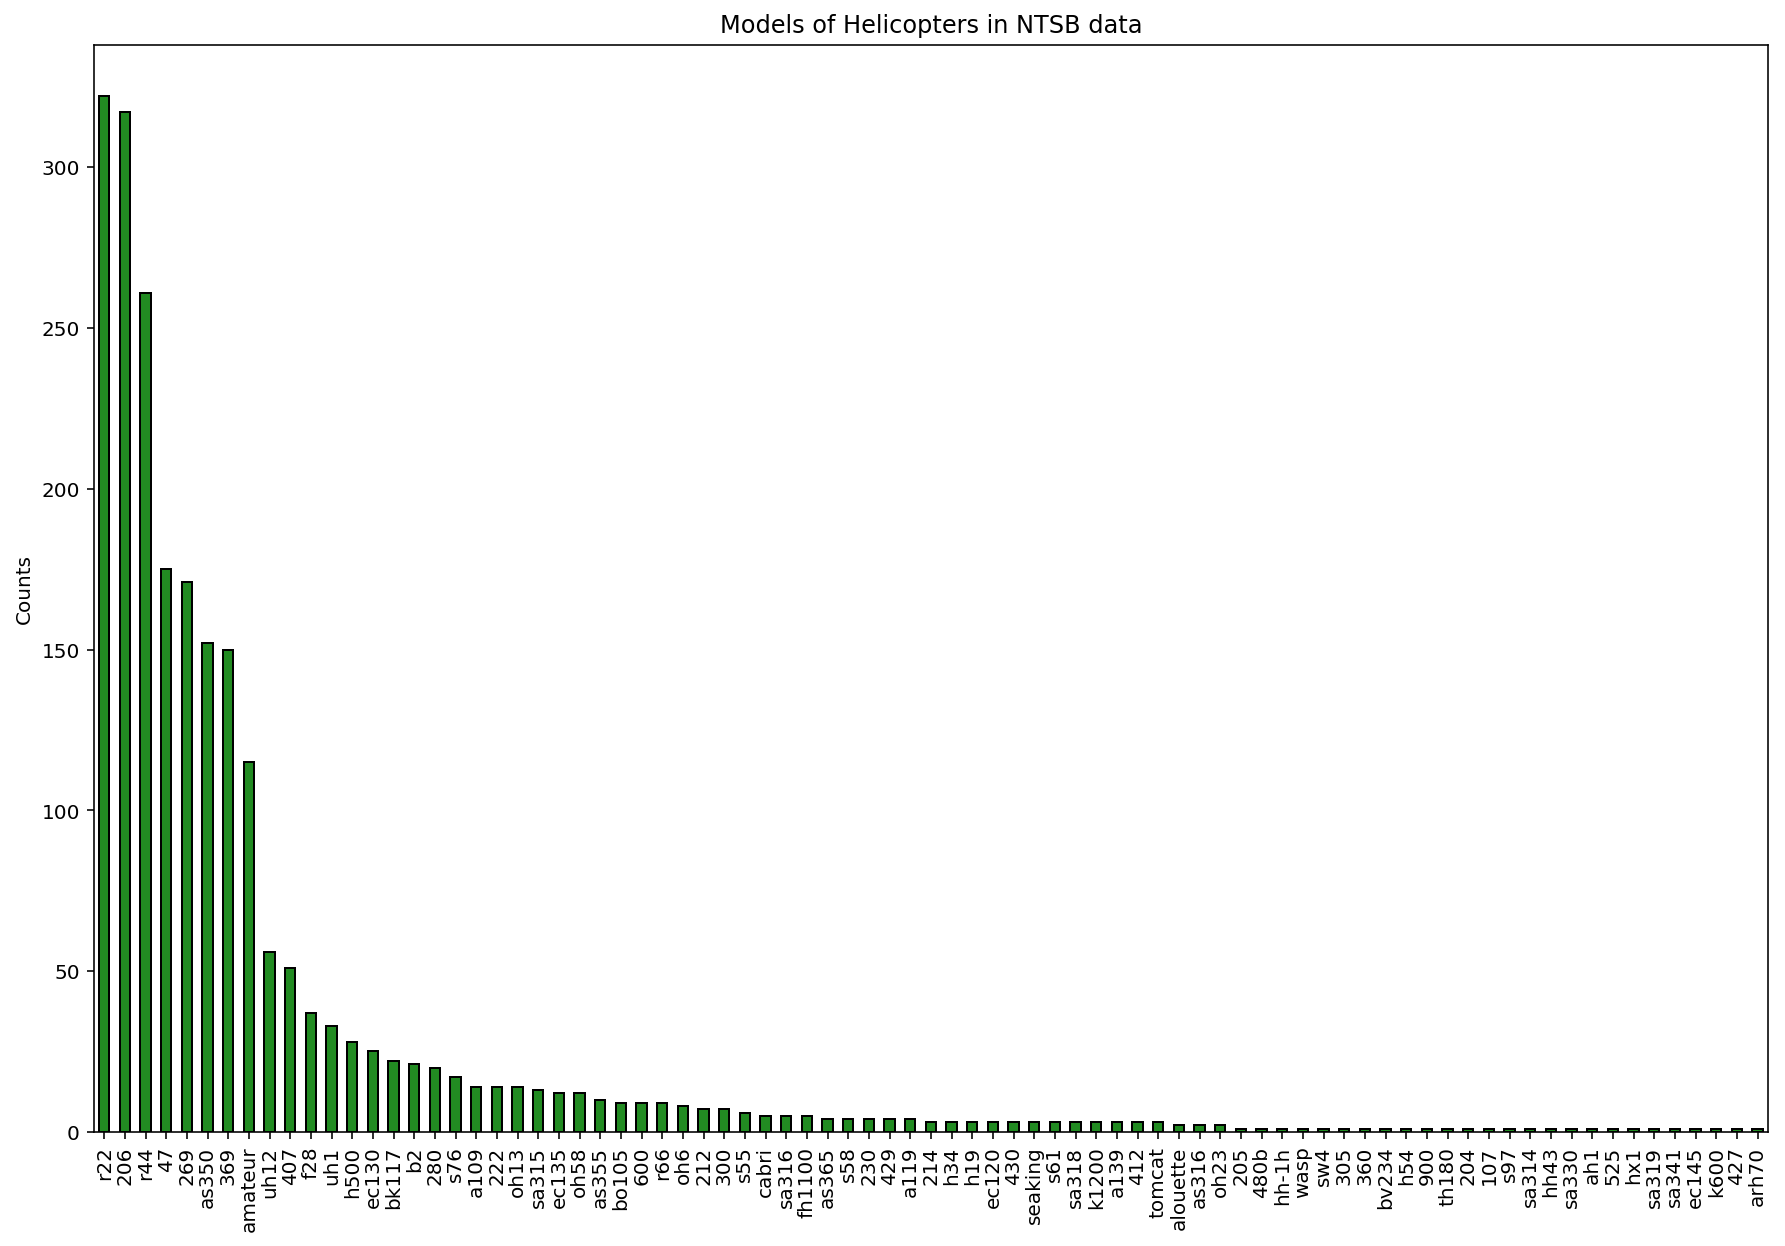

In [197]:
fig,ax = plt.subplots(figsize = [15,10])
ax = us_df.model.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen')
ax.set_ylabel('Counts')
_ = ax.set_title('Models of Helicopters in NTSB data')

There are several models of very few values. This is not helpful for modelling therefore will make a 'minority' model for models of less than 30 counts.

In [198]:
temp=us_df.model.value_counts()
model_dict={}
for model in temp.index:
    model_dict[model]= temp.loc[model]


In [199]:
def threshold(model, model_dict):
    if model_dict[model]>30:
        return model
    else:
        return 'minority'
    
us_df['model1']=us_df.model.apply(threshold, model_dict=model_dict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [50]:
us_df.model1.value_counts()

minority    380
r22         322
206         317
r44         261
47          175
269         171
as350       152
369         150
amateur     115
uh12         56
407          51
f28          37
uh1          33
Name: model1, dtype: int64

##  

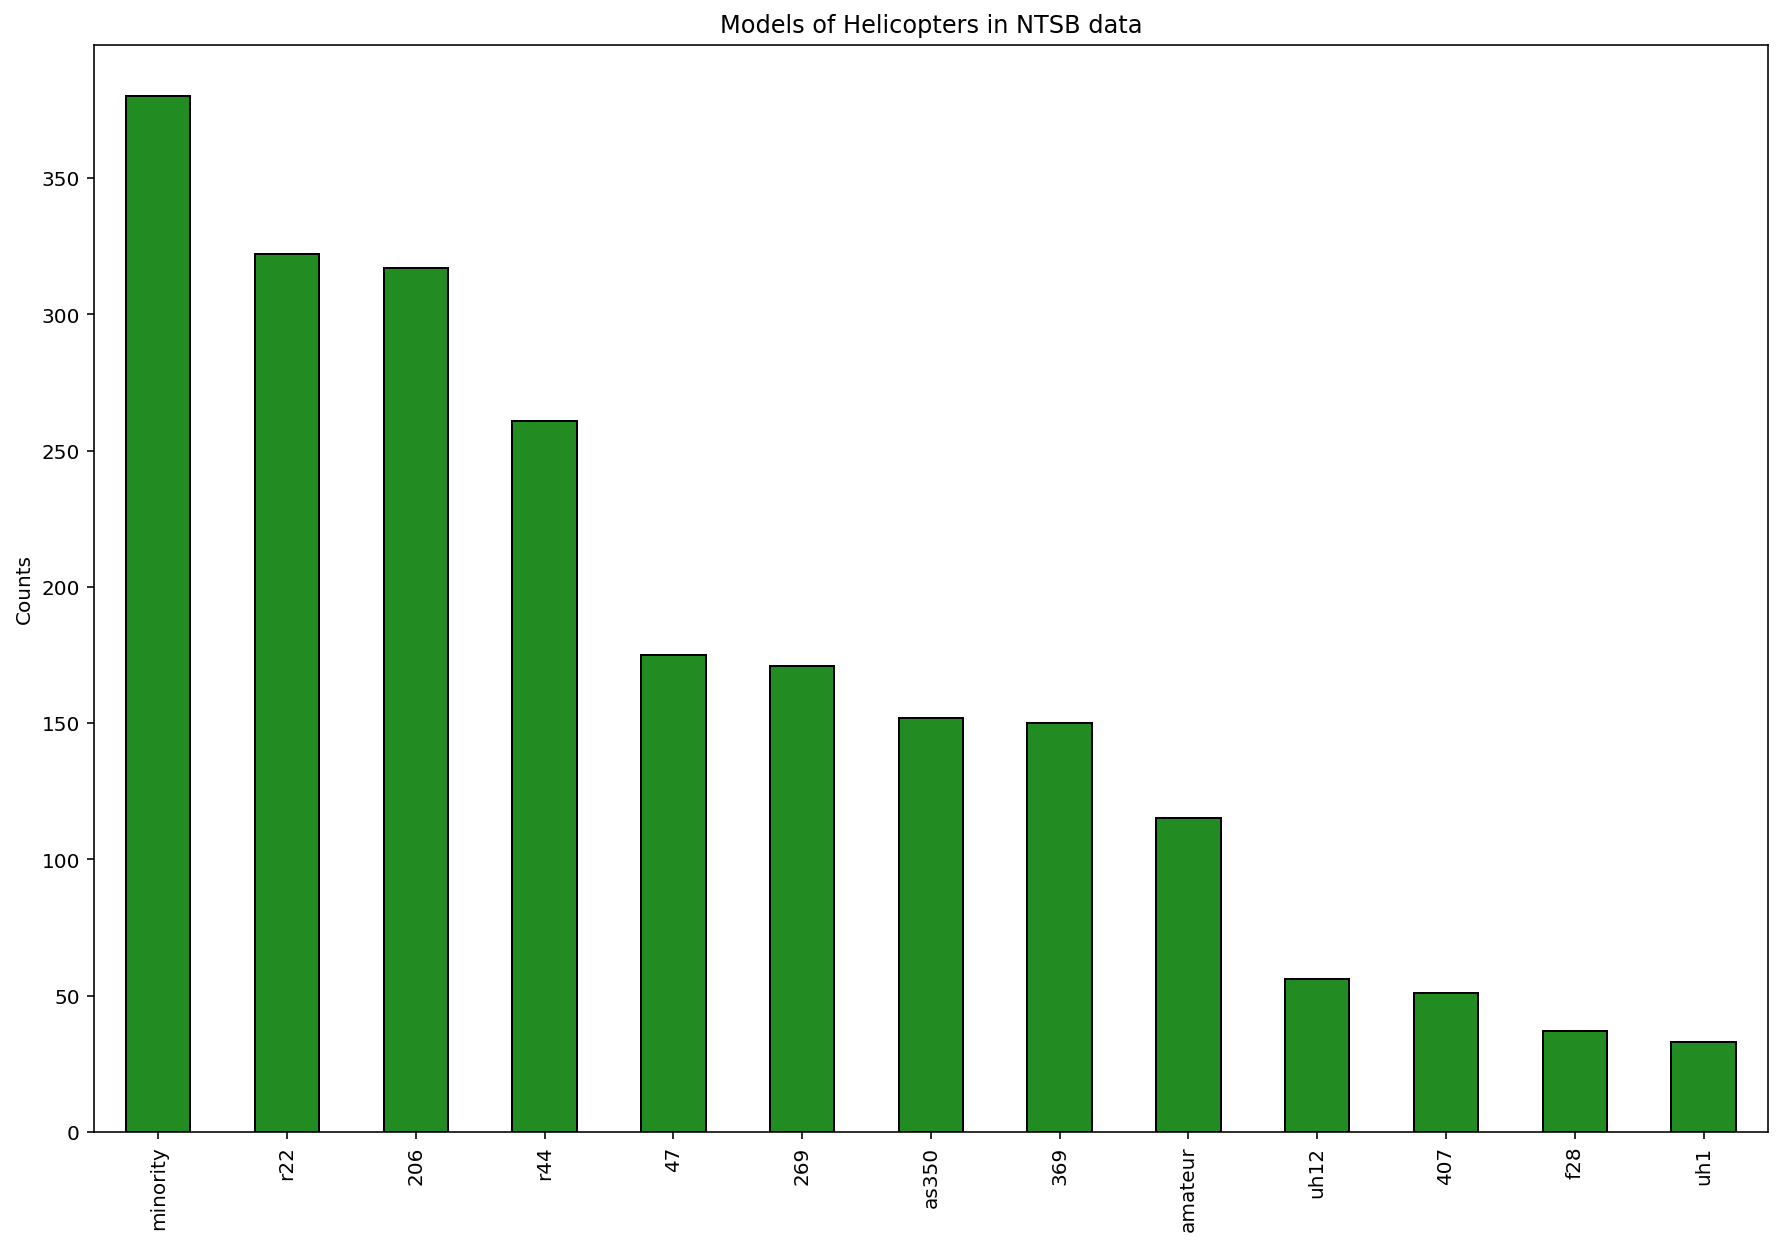

In [51]:
fig,ax = plt.subplots(figsize = [15,10])
ax = us_df.model1.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen')
ax.set_ylabel('Counts')
_ = ax.set_title('Models of Helicopters in NTSB data')

##  

## Looking at spread of fatalities over time

In [52]:
us_df['date'] = pd.to_datetime(us_df.event_date)
us_df.set_index('date', inplace=True, drop = True)
us_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,...,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities,model1
date,,,,,,,,,,,,,,,,,,,,,
2019-04-16,hughes,369,turbine,no,2019-04-16,"Hauula, HI",united_states,Non-Fatal,business,vmc,...,21.588333,-157.911944,substantial,accident,Tuesday,4,1,professional,non_fatal,369
2019-04-04,robinson,r44,reciprocating,no,2019-04-04,"Tampa, FL",united_states,Fatal(1),private,vmc,...,27.943333,-82.401944,substantial,accident,Thursday,4,1,private,fatal,r44
2019-04-02,robinson,r44,reciprocating,no,2019-04-02,"Taunton, MA",united_states,Non-Fatal,instructional,vmc,...,41.874445,-71.016389,substantial,accident,Tuesday,4,1,instructional,non_fatal,r44
2019-03-30,bell,222,turbine,no,2019-03-30,"Montgomery, NY",united_states,Non-Fatal,private,vmc,...,41.539444,-74.306944,substantial,accident,Saturday,3,2,private,non_fatal,minority
2019-03-29,bell,206,turbine,no,2019-03-29,"Valley Center, CA",united_states,Non-Fatal,survey,unknown,...,33.218370,-117.034197,substantial,accident,Friday,3,1,professional,non_fatal,206


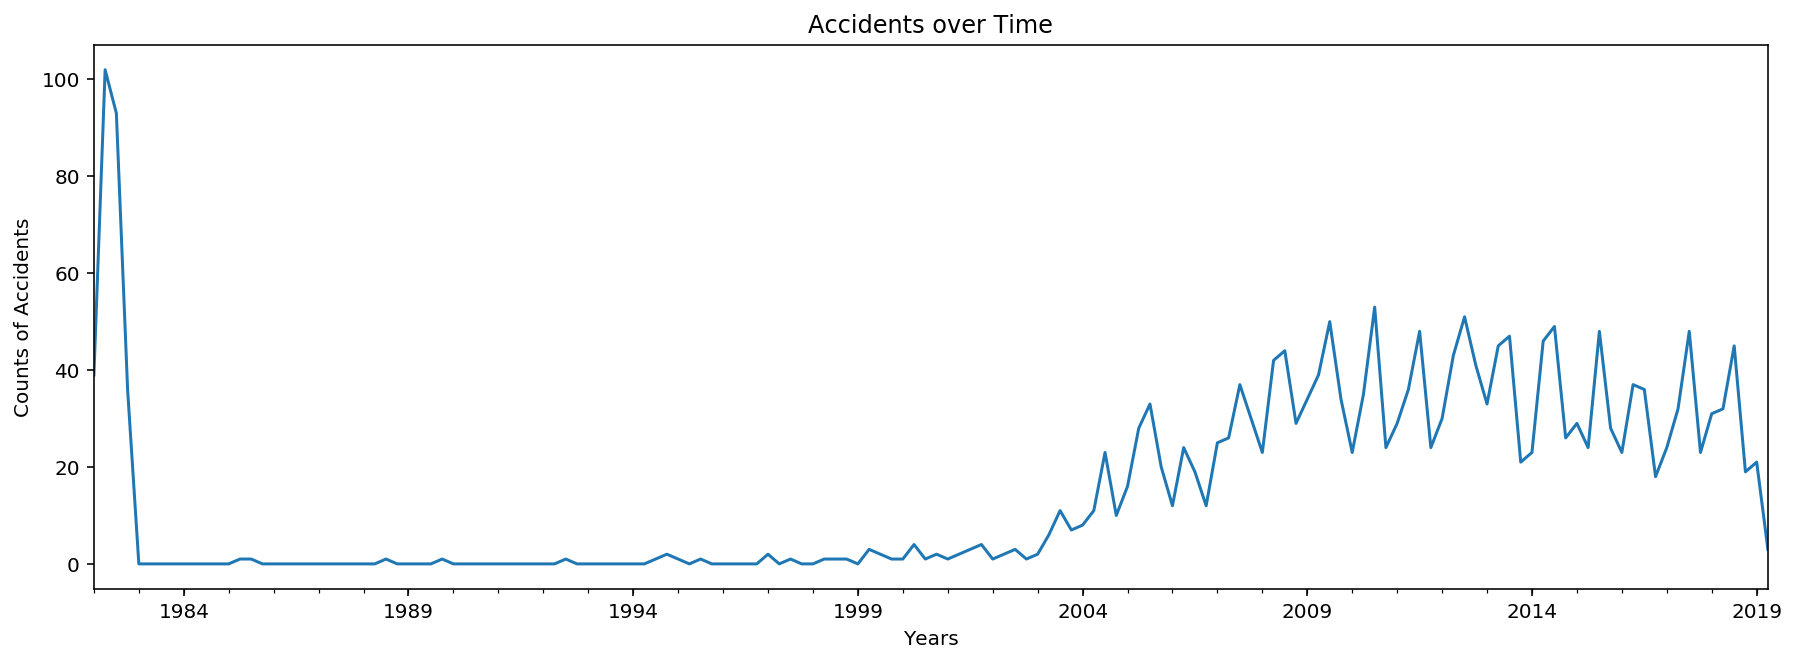

In [88]:
fig,ax = plt.subplots(figsize = [15,10])
us_df.resample('Q')['make'].count().plot(figsize = [15,5])
_ = ax.set_title('Accidents over Time')
plt.xlabel('Years')
ax.set_ylabel('Counts of Accidents');

It's interesting to see that there are very few reports before 2003. On looking at the NTSB website, the first spreadsheet of aviation accidents/incidents was 1998. 
From looking at the graph above, I've made the assumption that before 2003, there may not have been thorough processes/reporting protocols in place resulting in adhoc reporting until 2003. 

In [54]:
us_df['year']= us_df.index.year

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [147]:
us_df.groupby(['year'])['total_fatal_injuries'].sum().plot(kind='bar', figsize = (14,8))
plt.ylabel('Count')
plt.title("Sum of Fatalities by Month");

KeyError: 'year'

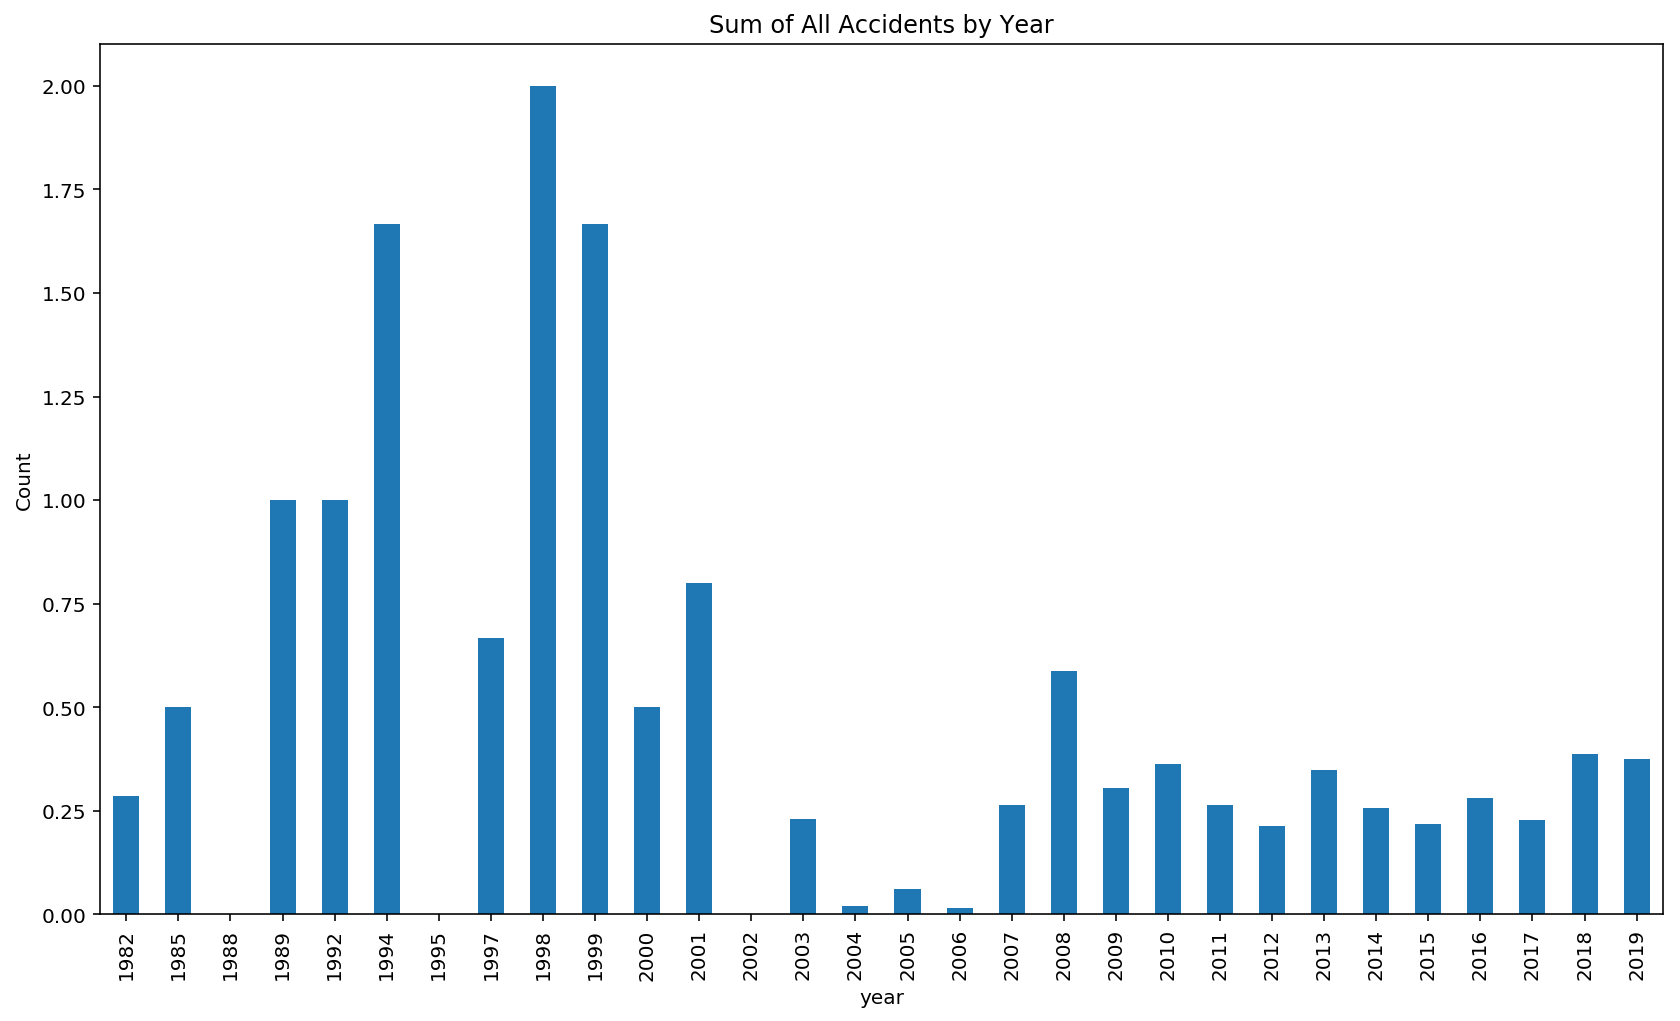

In [89]:
us_df.groupby(['year'])['total_fatal_injuries'].mean().plot(kind='bar', figsize = (14,8))
plt.ylabel('Count')
plt.title("Sum of All Accidents by Year");

The graphs above show that of the few reports prior to 2003, it was mainly accidents that had a fatality that were reported. For this reason, I will only work with reports from 2003 onwards.



In [57]:
mask_2003 = us_df['year'] >2002
usdf2003= us_df[mask_2003]

In [58]:
usdf2003.event_date.head(1)

date
2019-04-16    2019-04-16
Name: event_date, dtype: object

In [59]:
usdf2003.event_date.tail(1)

date
2003-01-10    2003-01-10
Name: event_date, dtype: object

##  

##  Dropping unnecessary columns

Dropping phase of flight as it does not add value, and I have broad phase of flight.   

Dropping purpose of flight as information from this column has been used to generate the pilot type column where there is an assumption that all accidents that are not private, instructional or unknown are professional pilots who fly for a career therefore are trained to a higher level,and they also have more experience.
   
Dropping year, event_date as they are not needed.
  
Dropping amateur_built as this is replicated in Make.

Dropping aircraft_damage as this as a result of the accident.

Dropping model as there is now a column model1 with grouped minorities.

Dropping longitude and latitude as they do not add value - already used in EDA in Tableau.

Dropping the 'injuries' columns so my target isn't in my predictor

Dropping location

In [60]:
usdf2003.columns

Index(['make', 'model', 'engine_type1', 'amateur_built', 'event_date',
       'location', 'country', 'injury_severity', 'purpose_of_flight',
       'weather_condition', 'broad_phase_of_flight', 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured',
       'people_on_board', 'phase_of_flight', 'latitude', 'longitude',
       'aircraft_damage', 'investigation_type', 'day_of_week', 'month',
       'no_of_engines1', 'pilot_type', 'fatalities', 'model1', 'year'],
      dtype='object')

In [61]:
usdf2003=usdf2003.drop(['phase_of_flight', 'purpose_of_flight', 'year', 'event_date','amateur_built',  'aircraft_damage', 'model', 'longitude', 'latitude'], axis=1)


In [62]:
usdf2003=usdf2003.drop(['total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured', 'location'], axis=1)

In [63]:
usdf2003=usdf2003.drop(['investigation_type'], axis=1)

In [64]:
usdf2003=usdf2003.drop(['injury_severity'], axis=1)

In [65]:
usdf2003=usdf2003.drop(['country'], axis=1)

In [66]:
usdf2003=usdf2003.reset_index().drop(columns=['date'])

In [67]:
usdf2003.head()

,make,engine_type1,weather_condition,broad_phase_of_flight,people_on_board,day_of_week,month,no_of_engines1,pilot_type,fatalities,model1
0,hughes,turbine,vmc,cruise,4.0,Tuesday,4,1,professional,non_fatal,369
1,robinson,reciprocating,vmc,cruise,4.0,Thursday,4,1,private,fatal,r44
2,robinson,reciprocating,vmc,maneuvering,2.0,Tuesday,4,1,instructional,non_fatal,r44
3,bell,turbine,vmc,takeoff,6.0,Saturday,3,2,private,non_fatal,minority
4,bell,turbine,unknown,unknown,1.0,Friday,3,1,professional,non_fatal,206


In [68]:
usdf2003.to_csv('usdf_2003_without_index.csv')

In [69]:
usdf2003.columns

Index(['make', 'engine_type1', 'weather_condition', 'broad_phase_of_flight',
       'people_on_board', 'day_of_week', 'month', 'no_of_engines1',
       'pilot_type', 'fatalities', 'model1'],
      dtype='object')